# LSH: Intel Images: VGG19

Using the Intel Images dataset, we will read the entire set of data files into memory as thier grayscale variants (in order to reduce dataset hashing time), then utilize the a custom hashing function of which generates a set of fixed length binary strings, each representing a different potential locality-sensifive hash of the image. The no preprocessing variant utilizes 150x150x3 images --> 67,500 features. The small grayscale variant utilizes 75x75x1 images --> 5,625 features. For the LSH, 1,024 hashes (32x32) is chosen instead, since 32x32 is the smallest possible dimensions which will be accepted accoss all model architectures (allowing this value to be consistent across all experiments).  In order to accomodate a model with the same size using the different preprocessing scheme. Each hash will be chosen as an 8-bit number in base 10 representation (0-255) then scaled in the same way that a pixel value would be (min-max scaling). 

It is hypothesized that this preprocessing may not yield any benefit when training on a convolutional neural network, as it will not see benefits from the convolutions, since hash strings are generated from random locations within the image, so the idea of relative positioning of the hashes is not significant. 

## Imports

Before we begin, we need to import the necessary python packages and appropriately configure the tensorflow gpu enviornment for use with the correct GPU on this system (RTX 2070 in GPU slot 0). 

* **`numpy`:** used for matrix operations, storing the pixel data of the images while working
* **`pandas`:** used for tabular organization of the results for storing in a formatted csv style for later evaluation in another notebook
* **`matplotlib.pyplot`:** used for data visualization for the model performance after training
* **`cv2`:** OpenCV for python, used for reading and manipulating the image files from the dataset before storing in working memory.
* **`os`:** used for streamlined access of the filesystem for determining the paths to each of the data files
* **`tensorflow.keras`:** used for model creation, compiling, and training. The GPU variant of tensorflow was used; this program has not been tested for systems without access to the GPU acclerations. 
* **`sklearn.utils.shuffle`:** used for an efficient shuffling of the X and y datasets together. 
* **`sklearn.decomposition.PCA`** used for principle component analysis. It was decided that the library implementation should be used instead of an application-specific optimized implementation in order to better reflect the general usage case rather than fringe usages. 
* **`timeit.default_timer`:** used for timing the overhead and training runtime performance of the model when no preprocessing is performed

In [1]:
# === Imports === #
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import kerastuner        as kt
import cv2
import os
from tensorflow            import keras
from sklearn.utils         import shuffle
from timeit                import default_timer


# === Extra Configurations for the GPU Environment === #
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# === Total Times Log === #
times = list( )

## Determine Train/Test Data Files

First, we need to determine the files which are to be used for training and validation. In order to do this, we will use our knowledge of the filesystem structure for the project, as well as the os listdir function to produce two lists: one of the filepaths used for the training data, and one of the filepaths used for the validation data. Finally, the first ten items of each list are printed to verify the success of the file list creation. 

In [2]:
# === Setup Variables === #
data_root_dir   = 'Dataset/Intel_Images/'
training_subdir = 'seg_train/seg_train/'
testing_subdir  = 'seg_test/seg_test/'
data_classes    = os.listdir( data_root_dir + training_subdir )
training_files  = [ ]
testing_files   = [ ]


# === For Each Class, Add Files to Appropriate List === #
for data_class in data_classes:
    for f in os.listdir( data_root_dir + training_subdir + data_class + '/' ):
        training_files.append( data_root_dir + training_subdir + data_class + '/' + f )
    for f in os.listdir( data_root_dir + testing_subdir + data_class + '/' ):
        testing_files.append( data_root_dir + testing_subdir + data_class + '/' + f )

    
# === Show First 10 of Each to Prove Success === #
print( 'Training Set:\n{}'.format( training_files[:10] ) )
print( '\nTesting Set: \n{}'.format( testing_files[:10] ) )

Training Set:
['Dataset/Intel_Images/seg_train/seg_train/buildings/0.jpg', 'Dataset/Intel_Images/seg_train/seg_train/buildings/10006.jpg', 'Dataset/Intel_Images/seg_train/seg_train/buildings/1001.jpg', 'Dataset/Intel_Images/seg_train/seg_train/buildings/10014.jpg', 'Dataset/Intel_Images/seg_train/seg_train/buildings/10018.jpg', 'Dataset/Intel_Images/seg_train/seg_train/buildings/10029.jpg', 'Dataset/Intel_Images/seg_train/seg_train/buildings/10032.jpg', 'Dataset/Intel_Images/seg_train/seg_train/buildings/10056.jpg', 'Dataset/Intel_Images/seg_train/seg_train/buildings/1009.jpg', 'Dataset/Intel_Images/seg_train/seg_train/buildings/10113.jpg']

Testing Set: 
['Dataset/Intel_Images/seg_test/seg_test/buildings/20057.jpg', 'Dataset/Intel_Images/seg_test/seg_test/buildings/20060.jpg', 'Dataset/Intel_Images/seg_test/seg_test/buildings/20061.jpg', 'Dataset/Intel_Images/seg_test/seg_test/buildings/20064.jpg', 'Dataset/Intel_Images/seg_test/seg_test/buildings/20073.jpg', 'Dataset/Intel_Images/seg

## Get Image Data & Label from File Names

Using our two file lists, we need to read the image data into working memory for the model to use in the training process. Since our model requires all training and validation data to be of the same shape, reshaping the image as its read will be the only transformation performed on the data. For the Intel Images dataset, all images are exactly `150x150`. As specified at the start of this notebook, due to the model architectures experimented with for this project, the smallest possible hash size which can be utilized consistently across the experimented architectures is 32x32. However, that `32x32` is not extracted at the time of reading the dataset. Rather, it is computed in future cells. For now, `150x150` is read into memory in order to be consistent with the PCA and unprocessed variants. We keep the read images as 8-bit integers without regularization since we will be performing min-max scaling later in the hashing step. We read the images in as their grayscale variants since color information is lost during the hashing process, and it improves the overhead time for this processing step.

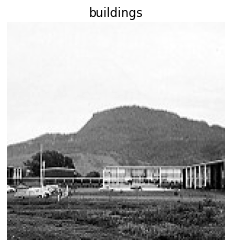

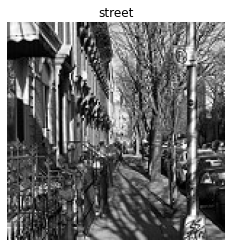

In [3]:
# ================================================================================
# FUNCTION: files_to_Xy( file_list , desired_shape )
# ================================================================================
# 
# Input: 
#   - file_list: list of filepaths to be read (as generated in the previous cell)
#   - desired_shape (optional): dimensions to transform the image data into
#        * default = (150,150,1): a 150x150 grayscale image
#
# Output:
#   - Numpy array of shape (n,h,w,c) containing every image present in the list
#        * n = number of images listed to be read
#        * h = first dimension of desired_shape: height of image 
#        * w = second dimension of desired_shape: width of image
#        * c = third dimension of desired_shape: number of channels in the image (RGB=3)
#
# Task:
#   1. Iterate over the file list
#   2. Parse the y label for the image out of the file path
#   3. Use OpenCV (cv2) to read the image data and reshape appropriately
#   4. store the image data/label into numpy arrays of the desired shape
#   5. return the populated X and y after finished iterating
#
# ================================================================================
def files_to_Xy( file_list , desired_shape=(150,150,1) ):
    
    # === Setup Variables === #
    X = np.empty( (len( file_list ), desired_shape[0]*desired_shape[1]*desired_shape[2] ) , dtype=np.uint8 )
    y = np.empty( len( file_list ) , dtype=object )
    
    # === Iterate Files === #
    for i in range( len( file_list ) ):
        y[i] = file_list[i].split( '/' )[4]
        X[i] = cv2.resize( 
                    cv2.imread( file_list[i] , cv2.IMREAD_GRAYSCALE ), 
                    ( desired_shape[0] , desired_shape[1] ) 
                ).flatten( )  # read as rgb instead of bgr
        
    # === Return Results === #
    return X , y



# ================================================================================
# FUNCTION: show_image( X , y , idx )
# ================================================================================
#
# Input:
#   - X: numpy array containing the image data
#   - y: numpy array containing the corresponding class labels
#   - idx: index of the image to be shown
#
# Output:
#   - no return
#   - matplotlib imshow figure displayed
#
# Task:
#   1. using matplotlib.pyplot.imshow() to display the specified image
#
# Note:
#   - This function is not necessary for program completion, but it serves as a 
#     utility function to help demonstrate the success of the other necessary 
#     functions. 
#
# ================================================================================
def show_image( X , y , idx , shape=(150,150,1) ):
    plt.figure( )
    plt.axis( 'off' )
    plt.imshow( X[idx].reshape(shape) , cmap='gray' )
    plt.title( y[idx] )
    plt.show( )
        
        
        
# === Use Function to Get Train/Test Data === #
start             = default_timer( )
X_train , y_train = files_to_Xy( training_files )
X_test  , y_test  = files_to_Xy( testing_files  )
end               = default_timer( )
times.append( { 'Event': 'Load/Process Dataset' , 'Time (sec)': end - start } )



# === Show First and Last Images and Classes as Proof === #
show_image( X_train , y_train , 0 )
show_image( X_train , y_train , y_train.shape[0] - 1 )

## Shuffle the Training Data

Shuffling the training data is an important step to be performed before training any model. This helps to allow fairness in the training, and ensure the model is learning most effectively without encountering any biases due to ordering (for example, all cats are listed before all dogs currently, so the model may overfit to dogs before learning anything about cats).

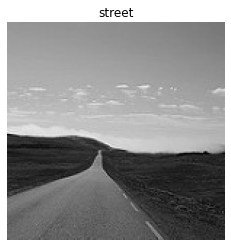

In [4]:
# === Shuffle X and y Together === #
X_train , y_train = shuffle( X_train , y_train )


# === Prove by Printing First Again to show it's Different === #
show_image( X_train , y_train , 0 )

## LSH: Create the Hash Functions

The first step to LSH is to create the functions used for hashing the dataset. For the purposes of this experiment, we will generate 1,024 different hash functions (to reshape into 32x32 "hash images"), each selects 8 random pixels from the image and determines whether those 8 pixels are greater than a random threshold. 

In [5]:
# ========================================================
# create_single_hash_function
# ========================================================
# Input: 
#   - dimensions: k-dimensional numpy array of random pixel
#                 indices
#   - thresholds: k-dimensional numpy array of random threshold values
#                 for those pixels to be flagged
# Output:
#   - lambda expression which will hash a pixel vector into a
#     k-bit string
# Task:
#   - for each of the k items in dimensions and thresholds
#   - if the input vector for the lambda at the specified 
#     dimension is > the corresponding threshold, report '1',
#     otherwise report '0'
#   - Concate the generated list of chars into a string
#   - return the lambda expression which performs the above 
#     tasks
# ========================================================
def create_single_hash_function( dimensions , thresholds ):
    return lambda v: np.sum( 
                    [ 2**i if v[ dimensions[i] ] > thresholds[i] 
                      else 0
                      for i in range( len( dimensions ) ) ] )


# ========================================================
# create_hash_function_list
# ========================================================
# Input: 
#   - L: number of hash functions to make
#   - k: length of each hash string
#   - max_dimension: largest valid index of the pixel vectors
#   - min_threshold=0: smallest valid value in the vectors being hashed
#   - max_threshold=255: largest valid value in the vectors being hashed
# Output:
#   - list of L different hash functions which take input vector v
#     and return a length-k string of '0's and '1'
# Task:
#   - Iterate L times:
#   - generate k random indices
#   - generate k random corresponding thresholds 
#   - Call create_single_hash_function with the generated 
#     dimensions and thresholds
#   - append the generated lambda expression to a list
#   - After generation is finished, return the list of 
#     lambda expressions
# ========================================================
def create_hash_function_list( L , k , max_dimension , min_threshold=0 , max_threshold=255 ):
    functions = list( )
    for i in range( L ):
        dimensions = np.random.randint( low=0             , high=max_dimension , size=k )
        thresholds = np.random.randint( low=min_threshold , high=max_threshold , size=k )
        functions.append( create_single_hash_function( dimensions , thresholds ) )
    return functions


# === Time the Construction of Hash Function List === #
start          = default_timer( )
dims           = 32
hash_functions = create_hash_function_list( L=dims*dims , k=8 , max_dimension=len( X_train[0] ) )
end            = default_timer( )
times.append( { 'Event': 'Create Hash Functions' , 'Time (sec)': end - start } )


# === Output Number of Functions Created to Show Success === #
print( 'Number of Hash Functions: ' , len( hash_functions ) )

Number of Hash Functions:  1024


## LSH

Using the hash functions, we now produce a list of hashes for each of the training and validation data items. This reduces the dimensionality of the original images from 48,000 (or 16,000 since we use the grayscale variant in this process) to 1,024 (32x32).

In [6]:
# ========================================================
# create_hashed_data_array
# ========================================================
# Input: 
#   - L: number of hash functions to make
#   - k: length of each hash string
#   - data: numpy array where each row is a pixel vector
#   - hash_functions: list of functions/lambdas which will hash
#     a given vector
# Output:
#   - new array where each row contains the L hash strings 
#     of the corresponding data row
# Task:
#   - initialize an empty numpy array of the right shape
#   - iterate over the hash functions
#   - apply the hash function to each row of the data at once
#   - update a column of the return array with the resulting 
#     hash stirngs
#   - once iteration finishes, return the array
# ========================================================
def create_hashed_data_array( L , k , dims , data , hash_functions ):
    hashed_data = np.empty( ( len( data ) , L ) , dtype=np.uint8 ) # NxL array of len-k strings
    for i in range( len( data ) ):
        for j in range( len( hash_functions ) ):
            hashed_data[i,j] = hash_functions[j]( data[i] )
    return hashed_data.reshape( len(data) , dims , dims , 1 ) / 255


# === Time to Hash the Data === #
start       = default_timer( )
X_train     = create_hashed_data_array( dims*dims , 8 , dims , X_train , hash_functions )
X_test      = create_hashed_data_array( dims*dims , 8 , dims , X_test  , hash_functions )
end         = default_timer( )
times.append( { 'Event': 'Hashing Datasets' , 'Time (sec)': end - start } )


# === Print First 2 Rows to Show Success === #
print( 'First Training Image\'s Hashes\n' , X_train[0] )

First Training Image's Hashes
 [[[0.02745098]
  [0.44313725]
  [0.65882353]
  ...
  [0.20784314]
  [0.25098039]
  [0.76470588]]

 [[0.14901961]
  [0.72941176]
  [0.43137255]
  ...
  [0.91372549]
  [0.74117647]
  [0.1372549 ]]

 [[0.79607843]
  [0.69803922]
  [0.61176471]
  ...
  [0.38039216]
  [0.07843137]
  [0.05098039]]

 ...

 [[0.45882353]
  [0.07058824]
  [0.25882353]
  ...
  [0.50588235]
  [0.12941176]
  [0.30588235]]

 [[0.3254902 ]
  [0.74509804]
  [0.21176471]
  ...
  [0.07058824]
  [0.52941176]
  [0.90588235]]

 [[0.10980392]
  [0.65490196]
  [0.10588235]
  ...
  [0.01176471]
  [0.09411765]
  [0.56470588]]]


In [7]:
print(times[-1])

{'Event': 'Hashing Datasets', 'Time (sec)': 350.4373933}


## Convert Classes from Strings to Integers

Keras models don't handle categorical classes as well as numerical classes -- especially fora  binary classifier. Because of this, instead of having multiple class categories, we will translate the possible classes to an integer valuea. 

    Buildings --> 0
    Forest --> 1
    Glacier --> 2
    Mountain --> 3
    Sea --> 4
    Street --> 5

Finally, the builtin keras functions `keras.utils.to_categorical()` is used to translate the numbered classes into categorical representation for use in the keras model whose output is determined by softmax. This translation is performed against both the training and validation labels.

In [8]:
# === Key to Translate in Either Direction
label_keys = {
    'buildings' : 0,
    'forest'    : 1,
    'glacier'   : 2,
    'mountain'  : 3,
    'sea'       : 4,
    'street'    : 5,
    0           : 'buildings',
    1           : 'forest',
    2           : 'glacier',
    3           : 'mountain',
    4           : 'sea',
    5           : 'street'
}

# === Iteratively Translate Labels === #
for c in data_classes:
    y_train[y_train==c] = label_keys[c]
    y_test[y_test==c]   = label_keys[c]

# === Update Data Types === #
y_train = y_train.astype( X_train.dtype )
y_test  = y_test.astype( X_test.dtype )
y_train = keras.utils.to_categorical( y_train )
y_test  = keras.utils.to_categorical( y_test )

# === Prove Success === #
y_train

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)

## Create Model with Tuning Options

We will be using a convolutional neural network, whose layers are specified to resemble the VGG19 model architecture. Consisting of 5 convolution blocks: 2x64, 2x128, 4x256, 4x512, 4x512. Each convolution block has a 2x2 pooling layer at the end of the block. After the five convolution blocks, the model is flattened, connected to a 1024 depth dense layer, then a dropout of 0.3, then a 64 depth dense layer, and finally a 1-depth dense layer for output. the ReLU activation function is used for all relevant layers with the exception of the output layer, which uses the softmax activation since this is a multi-class classification problem. 

In terms of tuning, we will test ten different learning rates between `1e-5` and `1e-4` in order to determine which one best converges in terms of accuracy. 

In [9]:
def model_builder( hp ):
    model_layers = [
        keras.Input( shape=X_train[0].shape , name='Input_Layer' ),
    
        keras.layers.Conv2D( 64 , kernel_size=(3,3) , activation='relu' , name='Conv_1_1' , padding='same' ),
        keras.layers.Conv2D( 64 , kernel_size=(3,3) , activation='relu' , name='Conv_1_2' , padding='same' ),
        keras.layers.MaxPooling2D( pool_size=(2,2) , name='Conv_1_Pooling' ),

        keras.layers.Conv2D( 128 , kernel_size=(3,3) , activation='relu' , name='Conv_2_1' , padding='same' ),
        keras.layers.Conv2D( 128 , kernel_size=(3,3) , activation='relu' , name='Conv_2_2' , padding='same' ),
        keras.layers.MaxPooling2D( pool_size=(2,2) , name='Conv_2_Pooling' ),

        keras.layers.Conv2D( 256 , kernel_size=(3,3) , activation='relu' , name='Conv_3_1' , padding='same' ),
        keras.layers.Conv2D( 256 , kernel_size=(3,3) , activation='relu' , name='Conv_3_2' , padding='same' ),
        keras.layers.Conv2D( 256 , kernel_size=(3,3) , activation='relu' , name='Conv_3_3' , padding='same' ),
        keras.layers.Conv2D( 256 , kernel_size=(3,3) , activation='relu' , name='Conv_3_4' , padding='same' ),
        keras.layers.MaxPooling2D( pool_size=(2,2) , name='Conv_3_Pooling' ),

        keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_4_1' , padding='same' ),
        keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_4_2' , padding='same' ),
        keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_4_3' , padding='same' ),
        keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_4_4' , padding='same' ),
        keras.layers.MaxPooling2D( pool_size=(2,2) , name='Conv_4_Pooling' ),

        keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_5_1' , padding='same' ),
        keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_5_2' , padding='same' ),
        keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_5_3' , padding='same' ),
        keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_5_4' , padding='same' ),
        keras.layers.MaxPooling2D( pool_size=(2,2) , name='Conv_5_Pooling' ),

        keras.layers.Flatten( ),

        keras.layers.Dense( 1024 , activation='relu' ),
        keras.layers.Dropout( 0.3 ),

        keras.layers.Dense( 64 , activation='relu' ),
        keras.layers.Dropout( 0.3 ),

        keras.layers.Dense( len(data_classes) , activation='softmax' )
    ]
    model            = keras.Sequential( layers=model_layers )
    hp_learning_rate = hp.Choice('learning_rate', values=list(np.linspace(0.0000001, 0.000001, 10)))
    optimizer        = keras.optimizers.Adam( lr=hp_learning_rate )
    model.compile( optimizer=optimizer , loss="categorical_crossentropy" , metrics=["accuracy"])
    return model

## Tune the Model

Using the keras-tuner package, we will tune the learning rate for the model in order to achieve the optimal validation accuracy via the hyperband tuning altorithm. This value may overfit, but it shows an example of how light tuning may result in better val accuracy in an automated tuning for this specific model architecture. 

In [10]:
start      = default_timer( )
tuner      = kt.Hyperband(model_builder, objective='val_accuracy', max_epochs=10, factor=3, hyperband_iterations=10, directory=os.path.normpath('C:/Users/dryyo/Documents/keras_tuner'), project_name='SmallGrayReg' , overwrite=True)
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
tuner.search(X_train, y_train, epochs=25, batch_size=16, validation_data=(X_test, y_test), callbacks=[stop_early])
best_hps   = tuner.get_best_hyperparameters(num_trials=1)[0]
end        = default_timer( )
times.append( { 'Event': 'Hyperparameter Tuning' , 'Time (sec)': end - start } )

print('The Optimal Leanring Rate is: {}'.format(best_hps.get('learning_rate')))

Train on 14034 samples, validate on 3000 samples
Epoch 1/2


 7760/14034 [===============>..............] - ETA: 34:08 - loss: 1.7917 - accuracy: 0.250 - ETA: 11:36 - loss: 1.7918 - accuracy: 0.208 - ETA: 5:56 - loss: 1.7918 - accuracy: 0.187 - ETA: 4:01 - loss: 1.7918 - accuracy: 0.22 - ETA: 3:21 - loss: 1.7918 - accuracy: 0.23 - ETA: 2:31 - loss: 1.7918 - accuracy: 0.20 - ETA: 2:09 - loss: 1.7918 - accuracy: 0.20 - ETA: 1:52 - loss: 1.7918 - accuracy: 0.20 - ETA: 1:44 - loss: 1.7918 - accuracy: 0.20 - ETA: 1:33 - loss: 1.7918 - accuracy: 0.19 - ETA: 1:28 - loss: 1.7918 - accuracy: 0.19 - ETA: 1:21 - loss: 1.7918 - accuracy: 0.18 - ETA: 1:17 - loss: 1.7918 - accuracy: 0.19 - ETA: 1:11 - loss: 1.7918 - accuracy: 0.18 - ETA: 1:09 - loss: 1.7918 - accuracy: 0.18 - ETA: 1:06 - loss: 1.7918 - accuracy: 0.18 - ETA: 1:04 - loss: 1.7918 - accuracy: 0.18 - ETA: 1:00 - loss: 1.7918 - accuracy: 0.19 - ETA: 59s - loss: 1.7918 - accuracy: 0.1981 - ETA: 56s - loss: 1.7918 - accuracy: 0.203 - ETA: 55s - loss: 1.7918 - accuracy: 0.200 - ETA: 53s - loss: 1.7918

14034/14034 [==============================] - ETA: 10s - loss: 1.7918 - accuracy: 0.183 - ETA: 10s - loss: 1.7918 - accuracy: 0.183 - ETA: 10s - loss: 1.7918 - accuracy: 0.183 - ETA: 9s - loss: 1.7918 - accuracy: 0.183 - ETA: 9s - loss: 1.7918 - accuracy: 0.18 - ETA: 9s - loss: 1.7918 - accuracy: 0.18 - ETA: 9s - loss: 1.7918 - accuracy: 0.18 - ETA: 9s - loss: 1.7918 - accuracy: 0.18 - ETA: 9s - loss: 1.7918 - accuracy: 0.18 - ETA: 9s - loss: 1.7918 - accuracy: 0.18 - ETA: 9s - loss: 1.7918 - accuracy: 0.18 - ETA: 9s - loss: 1.7918 - accuracy: 0.18 - ETA: 9s - loss: 1.7918 - accuracy: 0.18 - ETA: 9s - loss: 1.7918 - accuracy: 0.18 - ETA: 9s - loss: 1.7918 - accuracy: 0.18 - ETA: 9s - loss: 1.7918 - accuracy: 0.18 - ETA: 8s - loss: 1.7918 - accuracy: 0.18 - ETA: 8s - loss: 1.7918 - accuracy: 0.18 - ETA: 8s - loss: 1.7918 - accuracy: 0.18 - ETA: 8s - loss: 1.7918 - accuracy: 0.18 - ETA: 8s - loss: 1.7918 - accuracy: 0.18 - ETA: 8s - loss: 1.7918 - accuracy: 0.18 - ETA: 8s - loss: 1.7918

 7904/14034 [===============>..............] - ETA: 21s - loss: 1.7919 - accuracy: 0.0000e+0 - ETA: 18s - loss: 1.7918 - accuracy: 0.1406    - ETA: 19s - loss: 1.7918 - accuracy: 0.145 - ETA: 18s - loss: 1.7918 - accuracy: 0.166 - ETA: 19s - loss: 1.7918 - accuracy: 0.164 - ETA: 18s - loss: 1.7918 - accuracy: 0.183 - ETA: 18s - loss: 1.7917 - accuracy: 0.180 - ETA: 18s - loss: 1.7917 - accuracy: 0.181 - ETA: 18s - loss: 1.7918 - accuracy: 0.176 - ETA: 18s - loss: 1.7917 - accuracy: 0.185 - ETA: 18s - loss: 1.7917 - accuracy: 0.191 - ETA: 17s - loss: 1.7917 - accuracy: 0.185 - ETA: 18s - loss: 1.7917 - accuracy: 0.185 - ETA: 18s - loss: 1.7917 - accuracy: 0.184 - ETA: 17s - loss: 1.7917 - accuracy: 0.182 - ETA: 17s - loss: 1.7917 - accuracy: 0.183 - ETA: 17s - loss: 1.7917 - accuracy: 0.183 - ETA: 17s - loss: 1.7917 - accuracy: 0.179 - ETA: 17s - loss: 1.7917 - accuracy: 0.178 - ETA: 17s - loss: 1.7917 - accuracy: 0.177 - ETA: 17s - loss: 1.7917 - accuracy: 0.175 - ETA: 17s - loss: 1.79

14034/14034 [==============================] - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 7s - loss: 1.7917 - accuracy: 0.18 - ETA: 7s - loss: 1.7917 - accuracy: 0.18 - ETA: 7s - loss: 1.7917 - accuracy: 0.18 - ETA: 7s - loss: 1.7917 - accuracy: 0.18 - ETA: 7s - loss: 1.7917 - accuracy: 0.18 - ETA: 7s - loss: 1.7917 - accuracy: 0.18 - ETA: 7s - loss: 1.7917 - accuracy: 0.18 - ETA: 7s - loss: 1.7917 - accuracy: 0.18 - ETA: 7s - loss: 1.7917 - accuracy: 0.18 - ETA: 7s - loss: 1.7917 - accuracy: 0.18 - ETA: 7s - loss: 1.7917 - accuracy: 0.18 - ETA: 7s - loss: 1.7917 - accuracy: 0.18 - ETA: 7s - loss: 1.7917 - accuracy: 0.18 - ETA: 7s - loss: 1.7917 - accuracy: 0.18 - ETA: 7s - loss: 1.7917 - accuracy: 0.18 - ETA: 7s - loss: 1.7917 - accuracy: 0.18 - ETA: 7s - loss: 1.7917 - accuracy: 0.18 - ETA: 7s - loss: 1.7917 - accuracy: 0.18 - ETA: 6s - loss: 1.7917 - accuracy: 0.18 - ETA: 6s - loss: 1.7917 - accuracy: 0.18 - ETA: 6s - loss: 1.7917 - accu

Train on 14034 samples, validate on 3000 samples
Epoch 1/2


 7712/14034 [===============>..............] - ETA: 11:57 - loss: 1.7918 - accuracy: 0.125 - ETA: 3:10 - loss: 1.7918 - accuracy: 0.187 - ETA: 2:14 - loss: 1.7918 - accuracy: 0.14 - ETA: 1:27 - loss: 1.7918 - accuracy: 0.14 - ETA: 1:11 - loss: 1.7918 - accuracy: 0.14 - ETA: 1:00 - loss: 1.7918 - accuracy: 0.15 - ETA: 56s - loss: 1.7918 - accuracy: 0.1424 - ETA: 50s - loss: 1.7918 - accuracy: 0.133 - ETA: 48s - loss: 1.7918 - accuracy: 0.141 - ETA: 46s - loss: 1.7918 - accuracy: 0.145 - ETA: 44s - loss: 1.7918 - accuracy: 0.150 - ETA: 41s - loss: 1.7918 - accuracy: 0.147 - ETA: 40s - loss: 1.7918 - accuracy: 0.148 - ETA: 37s - loss: 1.7918 - accuracy: 0.149 - ETA: 35s - loss: 1.7918 - accuracy: 0.150 - ETA: 34s - loss: 1.7918 - accuracy: 0.160 - ETA: 32s - loss: 1.7918 - accuracy: 0.159 - ETA: 32s - loss: 1.7918 - accuracy: 0.160 - ETA: 31s - loss: 1.7918 - accuracy: 0.163 - ETA: 30s - loss: 1.7918 - accuracy: 0.168 - ETA: 29s - loss: 1.7918 - accuracy: 0.169 - ETA: 29s - loss: 1.7918 -

14034/14034 [==============================] - ETA: 9s - loss: 1.7917 - accuracy: 0.18 - ETA: 9s - loss: 1.7917 - accuracy: 0.18 - ETA: 9s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 7s - loss: 1.7917 - accuracy: 0.18 - ETA: 7s - loss: 1.7917 - accuracy: 0.18 - ETA: 7s - loss: 1.7917 - accuracy: 0.18 - ETA: 7s - loss: 1.7917 - accuracy: 0.18 - ETA: 7s - loss: 1.7917 - accu

 8000/14034 [================>.............] - ETA: 21s - loss: 1.7926 - accuracy: 0.187 - ETA: 17s - loss: 1.7916 - accuracy: 0.140 - ETA: 19s - loss: 1.7909 - accuracy: 0.197 - ETA: 18s - loss: 1.7911 - accuracy: 0.180 - ETA: 18s - loss: 1.7911 - accuracy: 0.181 - ETA: 18s - loss: 1.7909 - accuracy: 0.178 - ETA: 18s - loss: 1.7909 - accuracy: 0.175 - ETA: 18s - loss: 1.7910 - accuracy: 0.167 - ETA: 18s - loss: 1.7910 - accuracy: 0.159 - ETA: 18s - loss: 1.7910 - accuracy: 0.157 - ETA: 17s - loss: 1.7909 - accuracy: 0.165 - ETA: 18s - loss: 1.7910 - accuracy: 0.162 - ETA: 17s - loss: 1.7910 - accuracy: 0.162 - ETA: 18s - loss: 1.7909 - accuracy: 0.167 - ETA: 17s - loss: 1.7909 - accuracy: 0.172 - ETA: 17s - loss: 1.7908 - accuracy: 0.182 - ETA: 17s - loss: 1.7908 - accuracy: 0.183 - ETA: 17s - loss: 1.7908 - accuracy: 0.183 - ETA: 17s - loss: 1.7907 - accuracy: 0.183 - ETA: 17s - loss: 1.7907 - accuracy: 0.187 - ETA: 17s - loss: 1.7907 - accuracy: 0.182 - ETA: 17s - loss: 1.7908 - acc

14034/14034 [==============================] - ETA: 7s - loss: 1.7840 - accuracy: 0.18 - ETA: 7s - loss: 1.7839 - accuracy: 0.18 - ETA: 7s - loss: 1.7838 - accuracy: 0.18 - ETA: 7s - loss: 1.7836 - accuracy: 0.18 - ETA: 7s - loss: 1.7837 - accuracy: 0.18 - ETA: 7s - loss: 1.7836 - accuracy: 0.18 - ETA: 7s - loss: 1.7836 - accuracy: 0.18 - ETA: 7s - loss: 1.7834 - accuracy: 0.18 - ETA: 7s - loss: 1.7832 - accuracy: 0.18 - ETA: 7s - loss: 1.7832 - accuracy: 0.18 - ETA: 7s - loss: 1.7832 - accuracy: 0.18 - ETA: 7s - loss: 1.7832 - accuracy: 0.18 - ETA: 7s - loss: 1.7831 - accuracy: 0.18 - ETA: 7s - loss: 1.7829 - accuracy: 0.18 - ETA: 7s - loss: 1.7829 - accuracy: 0.18 - ETA: 7s - loss: 1.7828 - accuracy: 0.18 - ETA: 7s - loss: 1.7828 - accuracy: 0.18 - ETA: 6s - loss: 1.7827 - accuracy: 0.18 - ETA: 6s - loss: 1.7826 - accuracy: 0.18 - ETA: 6s - loss: 1.7824 - accuracy: 0.18 - ETA: 6s - loss: 1.7821 - accuracy: 0.18 - ETA: 6s - loss: 1.7820 - accuracy: 0.18 - ETA: 6s - loss: 1.7820 - accu

Train on 14034 samples, validate on 3000 samples
Epoch 1/2


 8000/14034 [================>.............] - ETA: 11:35 - loss: 1.7917 - accuracy: 0.250 - ETA: 4:06 - loss: 1.7917 - accuracy: 0.291 - ETA: 1:54 - loss: 1.7917 - accuracy: 0.25 - ETA: 1:25 - loss: 1.7918 - accuracy: 0.23 - ETA: 1:10 - loss: 1.7917 - accuracy: 0.22 - ETA: 59s - loss: 1.7917 - accuracy: 0.2031 - ETA: 55s - loss: 1.7917 - accuracy: 0.208 - ETA: 48s - loss: 1.7917 - accuracy: 0.196 - ETA: 44s - loss: 1.7918 - accuracy: 0.185 - ETA: 41s - loss: 1.7918 - accuracy: 0.189 - ETA: 39s - loss: 1.7917 - accuracy: 0.189 - ETA: 37s - loss: 1.7918 - accuracy: 0.181 - ETA: 36s - loss: 1.7918 - accuracy: 0.176 - ETA: 34s - loss: 1.7918 - accuracy: 0.180 - ETA: 34s - loss: 1.7918 - accuracy: 0.175 - ETA: 32s - loss: 1.7918 - accuracy: 0.170 - ETA: 31s - loss: 1.7918 - accuracy: 0.172 - ETA: 30s - loss: 1.7918 - accuracy: 0.176 - ETA: 29s - loss: 1.7918 - accuracy: 0.175 - ETA: 28s - loss: 1.7918 - accuracy: 0.175 - ETA: 28s - loss: 1.7918 - accuracy: 0.173 - ETA: 27s - loss: 1.7918 -

14034/14034 [==============================] - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 7s - loss: 1.7917 - accuracy: 0.17 - ETA: 7s - loss: 1.7917 - accuracy: 0.17 - ETA: 7s - loss: 1.7917 - accuracy: 0.17 - ETA: 7s - loss: 1.7917 - accuracy: 0.17 - ETA: 7s - loss: 1.7917 - accuracy: 0.17 - ETA: 7s - loss: 1.7917 - accuracy: 0.17 - ETA: 7s - loss: 1.7917 - accuracy: 0.17 - ETA: 7s - loss: 1.7917 - accuracy: 0.17 - ETA: 7s - loss: 1.7917 - accuracy: 0.17 - ETA: 7s - loss: 1.7917 - accuracy: 0.17 - ETA: 7s - loss: 1.7917 - accuracy: 0.17 - ETA: 7s - loss: 1.7917 - accuracy: 0.17 - ETA: 7s - loss: 1.7917 - accuracy: 0.17 - ETA: 7s - loss: 1.7917 - accuracy: 0.17 - ETA: 6s - loss: 1.7917 - accu

 8272/14034 [================>.............] - ETA: 19s - loss: 1.7918 - accuracy: 0.0000e+0 - ETA: 18s - loss: 1.7917 - accuracy: 0.1562    - ETA: 16s - loss: 1.7917 - accuracy: 0.187 - ETA: 18s - loss: 1.7916 - accuracy: 0.215 - ETA: 18s - loss: 1.7917 - accuracy: 0.201 - ETA: 18s - loss: 1.7917 - accuracy: 0.183 - ETA: 17s - loss: 1.7917 - accuracy: 0.177 - ETA: 18s - loss: 1.7917 - accuracy: 0.175 - ETA: 18s - loss: 1.7917 - accuracy: 0.164 - ETA: 17s - loss: 1.7917 - accuracy: 0.171 - ETA: 18s - loss: 1.7917 - accuracy: 0.161 - ETA: 17s - loss: 1.7917 - accuracy: 0.169 - ETA: 17s - loss: 1.7917 - accuracy: 0.161 - ETA: 17s - loss: 1.7917 - accuracy: 0.167 - ETA: 17s - loss: 1.7917 - accuracy: 0.174 - ETA: 17s - loss: 1.7917 - accuracy: 0.174 - ETA: 17s - loss: 1.7917 - accuracy: 0.165 - ETA: 17s - loss: 1.7917 - accuracy: 0.163 - ETA: 17s - loss: 1.7917 - accuracy: 0.167 - ETA: 17s - loss: 1.7917 - accuracy: 0.173 - ETA: 17s - loss: 1.7917 - accuracy: 0.177 - ETA: 17s - loss: 1.79

14034/14034 [==============================] - ETA: 7s - loss: 1.7917 - accuracy: 0.18 - ETA: 7s - loss: 1.7917 - accuracy: 0.18 - ETA: 7s - loss: 1.7917 - accuracy: 0.18 - ETA: 7s - loss: 1.7917 - accuracy: 0.18 - ETA: 7s - loss: 1.7917 - accuracy: 0.18 - ETA: 7s - loss: 1.7917 - accuracy: 0.18 - ETA: 7s - loss: 1.7917 - accuracy: 0.18 - ETA: 7s - loss: 1.7917 - accuracy: 0.18 - ETA: 7s - loss: 1.7917 - accuracy: 0.18 - ETA: 7s - loss: 1.7917 - accuracy: 0.18 - ETA: 7s - loss: 1.7917 - accuracy: 0.18 - ETA: 7s - loss: 1.7917 - accuracy: 0.18 - ETA: 7s - loss: 1.7917 - accuracy: 0.18 - ETA: 6s - loss: 1.7917 - accuracy: 0.18 - ETA: 6s - loss: 1.7917 - accuracy: 0.18 - ETA: 6s - loss: 1.7917 - accuracy: 0.18 - ETA: 6s - loss: 1.7917 - accuracy: 0.18 - ETA: 6s - loss: 1.7917 - accuracy: 0.18 - ETA: 6s - loss: 1.7917 - accuracy: 0.18 - ETA: 6s - loss: 1.7917 - accuracy: 0.18 - ETA: 6s - loss: 1.7917 - accuracy: 0.18 - ETA: 6s - loss: 1.7917 - accuracy: 0.18 - ETA: 6s - loss: 1.7917 - accu

Train on 14034 samples, validate on 3000 samples
Epoch 1/2


 7904/14034 [===============>..............] - ETA: 11:43 - loss: 1.7918 - accuracy: 0.250 - ETA: 4:09 - loss: 1.7918 - accuracy: 0.187 - ETA: 2:13 - loss: 1.7918 - accuracy: 0.13 - ETA: 1:33 - loss: 1.7918 - accuracy: 0.13 - ETA: 1:21 - loss: 1.7918 - accuracy: 0.14 - ETA: 1:03 - loss: 1.7918 - accuracy: 0.15 - ETA: 55s - loss: 1.7918 - accuracy: 0.1701 - ETA: 52s - loss: 1.7918 - accuracy: 0.168 - ETA: 47s - loss: 1.7918 - accuracy: 0.165 - ETA: 45s - loss: 1.7918 - accuracy: 0.180 - ETA: 42s - loss: 1.7918 - accuracy: 0.178 - ETA: 40s - loss: 1.7918 - accuracy: 0.177 - ETA: 38s - loss: 1.7917 - accuracy: 0.176 - ETA: 36s - loss: 1.7917 - accuracy: 0.178 - ETA: 35s - loss: 1.7917 - accuracy: 0.177 - ETA: 33s - loss: 1.7917 - accuracy: 0.180 - ETA: 32s - loss: 1.7917 - accuracy: 0.188 - ETA: 31s - loss: 1.7917 - accuracy: 0.186 - ETA: 31s - loss: 1.7917 - accuracy: 0.187 - ETA: 30s - loss: 1.7917 - accuracy: 0.187 - ETA: 30s - loss: 1.7917 - accuracy: 0.189 - ETA: 29s - loss: 1.7917 -

14034/14034 [==============================] - ETA: 9s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 7s - loss: 1.7917 - accuracy: 0.18 - ETA: 7s - loss: 1.7917 - accuracy: 0.18 - ETA: 7s - loss: 1.7917 - accuracy: 0.18 - ETA: 7s - loss: 1.7917 - accuracy: 0.18 - ETA: 7s - loss: 1.7917 - accuracy: 0.18 - ETA: 7s - loss: 1.7917 - accu

 7680/14034 [===============>..............] - ETA: 22s - loss: 1.7918 - accuracy: 0.062 - ETA: 19s - loss: 1.7917 - accuracy: 0.187 - ETA: 17s - loss: 1.7917 - accuracy: 0.196 - ETA: 19s - loss: 1.7918 - accuracy: 0.180 - ETA: 18s - loss: 1.7917 - accuracy: 0.173 - ETA: 18s - loss: 1.7917 - accuracy: 0.156 - ETA: 18s - loss: 1.7917 - accuracy: 0.163 - ETA: 18s - loss: 1.7917 - accuracy: 0.163 - ETA: 18s - loss: 1.7917 - accuracy: 0.168 - ETA: 18s - loss: 1.7917 - accuracy: 0.175 - ETA: 19s - loss: 1.7917 - accuracy: 0.187 - ETA: 18s - loss: 1.7917 - accuracy: 0.173 - ETA: 19s - loss: 1.7917 - accuracy: 0.172 - ETA: 18s - loss: 1.7917 - accuracy: 0.168 - ETA: 18s - loss: 1.7917 - accuracy: 0.171 - ETA: 18s - loss: 1.7917 - accuracy: 0.171 - ETA: 18s - loss: 1.7917 - accuracy: 0.173 - ETA: 18s - loss: 1.7917 - accuracy: 0.174 - ETA: 18s - loss: 1.7917 - accuracy: 0.176 - ETA: 18s - loss: 1.7917 - accuracy: 0.174 - ETA: 18s - loss: 1.7917 - accuracy: 0.170 - ETA: 18s - loss: 1.7917 - acc

14034/14034 [==============================] - ETA: 9s - loss: 1.7916 - accuracy: 0.18 - ETA: 8s - loss: 1.7916 - accuracy: 0.18 - ETA: 8s - loss: 1.7916 - accuracy: 0.18 - ETA: 8s - loss: 1.7916 - accuracy: 0.18 - ETA: 8s - loss: 1.7916 - accuracy: 0.18 - ETA: 8s - loss: 1.7916 - accuracy: 0.18 - ETA: 8s - loss: 1.7916 - accuracy: 0.18 - ETA: 8s - loss: 1.7916 - accuracy: 0.18 - ETA: 8s - loss: 1.7916 - accuracy: 0.18 - ETA: 8s - loss: 1.7916 - accuracy: 0.18 - ETA: 8s - loss: 1.7916 - accuracy: 0.18 - ETA: 8s - loss: 1.7916 - accuracy: 0.18 - ETA: 8s - loss: 1.7916 - accuracy: 0.18 - ETA: 8s - loss: 1.7916 - accuracy: 0.18 - ETA: 8s - loss: 1.7916 - accuracy: 0.18 - ETA: 8s - loss: 1.7916 - accuracy: 0.18 - ETA: 8s - loss: 1.7916 - accuracy: 0.18 - ETA: 8s - loss: 1.7916 - accuracy: 0.18 - ETA: 7s - loss: 1.7916 - accuracy: 0.18 - ETA: 7s - loss: 1.7916 - accuracy: 0.18 - ETA: 7s - loss: 1.7916 - accuracy: 0.18 - ETA: 7s - loss: 1.7916 - accuracy: 0.18 - ETA: 7s - loss: 1.7916 - accu

Train on 14034 samples, validate on 3000 samples
Epoch 1/2


 7776/14034 [===============>..............] - ETA: 11:43 - loss: 1.7918 - accuracy: 0.125 - ETA: 4:09 - loss: 1.7918 - accuracy: 0.208 - ETA: 1:56 - loss: 1.7918 - accuracy: 0.16 - ETA: 1:27 - loss: 1.7918 - accuracy: 0.12 - ETA: 1:11 - loss: 1.7918 - accuracy: 0.14 - ETA: 1:01 - loss: 1.7918 - accuracy: 0.14 - ETA: 56s - loss: 1.7918 - accuracy: 0.1528 - ETA: 50s - loss: 1.7918 - accuracy: 0.157 - ETA: 48s - loss: 1.7918 - accuracy: 0.163 - ETA: 44s - loss: 1.7918 - accuracy: 0.158 - ETA: 42s - loss: 1.7918 - accuracy: 0.156 - ETA: 40s - loss: 1.7918 - accuracy: 0.159 - ETA: 39s - loss: 1.7918 - accuracy: 0.162 - ETA: 37s - loss: 1.7918 - accuracy: 0.164 - ETA: 35s - loss: 1.7918 - accuracy: 0.165 - ETA: 34s - loss: 1.7918 - accuracy: 0.160 - ETA: 33s - loss: 1.7918 - accuracy: 0.163 - ETA: 32s - loss: 1.7918 - accuracy: 0.159 - ETA: 31s - loss: 1.7918 - accuracy: 0.159 - ETA: 30s - loss: 1.7918 - accuracy: 0.162 - ETA: 30s - loss: 1.7918 - accuracy: 0.159 - ETA: 29s - loss: 1.7918 -

14034/14034 [==============================] - ETA: 9s - loss: 1.7917 - accuracy: 0.17 - ETA: 9s - loss: 1.7917 - accuracy: 0.17 - ETA: 9s - loss: 1.7917 - accuracy: 0.17 - ETA: 9s - loss: 1.7917 - accuracy: 0.17 - ETA: 9s - loss: 1.7917 - accuracy: 0.17 - ETA: 9s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 7s - loss: 1.7917 - accu

 7808/14034 [===============>..............] - ETA: 18s - loss: 1.7928 - accuracy: 0.125 - ETA: 22s - loss: 1.7925 - accuracy: 0.125 - ETA: 18s - loss: 1.7923 - accuracy: 0.135 - ETA: 20s - loss: 1.7914 - accuracy: 0.171 - ETA: 18s - loss: 1.7908 - accuracy: 0.187 - ETA: 19s - loss: 1.7908 - accuracy: 0.182 - ETA: 19s - loss: 1.7908 - accuracy: 0.183 - ETA: 18s - loss: 1.7910 - accuracy: 0.171 - ETA: 19s - loss: 1.7911 - accuracy: 0.169 - ETA: 18s - loss: 1.7911 - accuracy: 0.169 - ETA: 18s - loss: 1.7910 - accuracy: 0.169 - ETA: 18s - loss: 1.7911 - accuracy: 0.162 - ETA: 18s - loss: 1.7910 - accuracy: 0.166 - ETA: 18s - loss: 1.7908 - accuracy: 0.173 - ETA: 18s - loss: 1.7908 - accuracy: 0.172 - ETA: 18s - loss: 1.7910 - accuracy: 0.170 - ETA: 18s - loss: 1.7909 - accuracy: 0.174 - ETA: 18s - loss: 1.7911 - accuracy: 0.170 - ETA: 18s - loss: 1.7910 - accuracy: 0.170 - ETA: 18s - loss: 1.7910 - accuracy: 0.167 - ETA: 18s - loss: 1.7908 - accuracy: 0.170 - ETA: 18s - loss: 1.7909 - acc

14034/14034 [==============================] - ETA: 8s - loss: 1.7876 - accuracy: 0.17 - ETA: 8s - loss: 1.7876 - accuracy: 0.17 - ETA: 8s - loss: 1.7876 - accuracy: 0.17 - ETA: 8s - loss: 1.7876 - accuracy: 0.17 - ETA: 8s - loss: 1.7876 - accuracy: 0.17 - ETA: 8s - loss: 1.7875 - accuracy: 0.17 - ETA: 8s - loss: 1.7875 - accuracy: 0.17 - ETA: 8s - loss: 1.7874 - accuracy: 0.17 - ETA: 8s - loss: 1.7873 - accuracy: 0.17 - ETA: 8s - loss: 1.7873 - accuracy: 0.17 - ETA: 8s - loss: 1.7873 - accuracy: 0.17 - ETA: 8s - loss: 1.7873 - accuracy: 0.17 - ETA: 7s - loss: 1.7872 - accuracy: 0.17 - ETA: 7s - loss: 1.7872 - accuracy: 0.17 - ETA: 7s - loss: 1.7872 - accuracy: 0.17 - ETA: 7s - loss: 1.7872 - accuracy: 0.17 - ETA: 7s - loss: 1.7872 - accuracy: 0.17 - ETA: 7s - loss: 1.7872 - accuracy: 0.17 - ETA: 7s - loss: 1.7872 - accuracy: 0.17 - ETA: 7s - loss: 1.7873 - accuracy: 0.17 - ETA: 7s - loss: 1.7872 - accuracy: 0.17 - ETA: 7s - loss: 1.7872 - accuracy: 0.17 - ETA: 7s - loss: 1.7871 - accu

Train on 14034 samples, validate on 3000 samples
Epoch 1/2


 7664/14034 [===============>..............] - ETA: 11:41 - loss: 1.7917 - accuracy: 0.187 - ETA: 4:08 - loss: 1.7918 - accuracy: 0.166 - ETA: 2:37 - loss: 1.7918 - accuracy: 0.16 - ETA: 1:45 - loss: 1.7918 - accuracy: 0.15 - ETA: 1:21 - loss: 1.7918 - accuracy: 0.15 - ETA: 1:08 - loss: 1.7918 - accuracy: 0.14 - ETA: 58s - loss: 1.7918 - accuracy: 0.1434 - ETA: 54s - loss: 1.7918 - accuracy: 0.151 - ETA: 49s - loss: 1.7918 - accuracy: 0.159 - ETA: 45s - loss: 1.7918 - accuracy: 0.152 - ETA: 42s - loss: 1.7918 - accuracy: 0.151 - ETA: 40s - loss: 1.7918 - accuracy: 0.151 - ETA: 38s - loss: 1.7918 - accuracy: 0.159 - ETA: 36s - loss: 1.7918 - accuracy: 0.157 - ETA: 35s - loss: 1.7918 - accuracy: 0.153 - ETA: 34s - loss: 1.7918 - accuracy: 0.150 - ETA: 33s - loss: 1.7918 - accuracy: 0.151 - ETA: 32s - loss: 1.7918 - accuracy: 0.156 - ETA: 31s - loss: 1.7918 - accuracy: 0.160 - ETA: 30s - loss: 1.7918 - accuracy: 0.163 - ETA: 29s - loss: 1.7918 - accuracy: 0.166 - ETA: 29s - loss: 1.7918 -

14034/14034 [==============================] - ETA: 9s - loss: 1.7917 - accuracy: 0.17 - ETA: 9s - loss: 1.7917 - accuracy: 0.17 - ETA: 9s - loss: 1.7917 - accuracy: 0.17 - ETA: 9s - loss: 1.7917 - accuracy: 0.17 - ETA: 9s - loss: 1.7917 - accuracy: 0.17 - ETA: 9s - loss: 1.7917 - accuracy: 0.17 - ETA: 9s - loss: 1.7917 - accuracy: 0.17 - ETA: 9s - loss: 1.7917 - accuracy: 0.17 - ETA: 9s - loss: 1.7917 - accuracy: 0.17 - ETA: 9s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accu

 7888/14034 [===============>..............] - ETA: 21s - loss: 1.7913 - accuracy: 0.187 - ETA: 17s - loss: 1.7918 - accuracy: 0.125 - ETA: 19s - loss: 1.7917 - accuracy: 0.145 - ETA: 17s - loss: 1.7918 - accuracy: 0.138 - ETA: 18s - loss: 1.7917 - accuracy: 0.142 - ETA: 18s - loss: 1.7917 - accuracy: 0.138 - ETA: 18s - loss: 1.7917 - accuracy: 0.132 - ETA: 18s - loss: 1.7917 - accuracy: 0.131 - ETA: 18s - loss: 1.7917 - accuracy: 0.136 - ETA: 18s - loss: 1.7917 - accuracy: 0.137 - ETA: 18s - loss: 1.7917 - accuracy: 0.138 - ETA: 18s - loss: 1.7916 - accuracy: 0.139 - ETA: 18s - loss: 1.7916 - accuracy: 0.144 - ETA: 18s - loss: 1.7916 - accuracy: 0.151 - ETA: 18s - loss: 1.7916 - accuracy: 0.157 - ETA: 18s - loss: 1.7916 - accuracy: 0.159 - ETA: 18s - loss: 1.7916 - accuracy: 0.159 - ETA: 18s - loss: 1.7916 - accuracy: 0.162 - ETA: 18s - loss: 1.7916 - accuracy: 0.156 - ETA: 18s - loss: 1.7916 - accuracy: 0.152 - ETA: 18s - loss: 1.7916 - accuracy: 0.150 - ETA: 18s - loss: 1.7916 - acc

14034/14034 [==============================] - ETA: 8s - loss: 1.7913 - accuracy: 0.18 - ETA: 8s - loss: 1.7913 - accuracy: 0.18 - ETA: 8s - loss: 1.7912 - accuracy: 0.18 - ETA: 8s - loss: 1.7912 - accuracy: 0.18 - ETA: 8s - loss: 1.7912 - accuracy: 0.18 - ETA: 8s - loss: 1.7912 - accuracy: 0.18 - ETA: 8s - loss: 1.7912 - accuracy: 0.18 - ETA: 8s - loss: 1.7912 - accuracy: 0.18 - ETA: 8s - loss: 1.7912 - accuracy: 0.18 - ETA: 8s - loss: 1.7912 - accuracy: 0.18 - ETA: 8s - loss: 1.7912 - accuracy: 0.18 - ETA: 7s - loss: 1.7912 - accuracy: 0.18 - ETA: 7s - loss: 1.7912 - accuracy: 0.18 - ETA: 7s - loss: 1.7912 - accuracy: 0.18 - ETA: 7s - loss: 1.7912 - accuracy: 0.18 - ETA: 7s - loss: 1.7912 - accuracy: 0.18 - ETA: 7s - loss: 1.7912 - accuracy: 0.18 - ETA: 7s - loss: 1.7912 - accuracy: 0.18 - ETA: 7s - loss: 1.7912 - accuracy: 0.18 - ETA: 7s - loss: 1.7912 - accuracy: 0.18 - ETA: 7s - loss: 1.7912 - accuracy: 0.18 - ETA: 7s - loss: 1.7912 - accuracy: 0.18 - ETA: 7s - loss: 1.7912 - accu

Train on 14034 samples, validate on 3000 samples
Epoch 1/2


 7920/14034 [===============>..............] - ETA: 11:47 - loss: 1.7918 - accuracy: 0.125 - ETA: 4:10 - loss: 1.7917 - accuracy: 0.208 - ETA: 2:38 - loss: 1.7918 - accuracy: 0.18 - ETA: 1:45 - loss: 1.7917 - accuracy: 0.21 - ETA: 1:29 - loss: 1.7918 - accuracy: 0.19 - ETA: 1:12 - loss: 1.7918 - accuracy: 0.17 - ETA: 1:02 - loss: 1.7918 - accuracy: 0.16 - ETA: 54s - loss: 1.7918 - accuracy: 0.1612 - ETA: 51s - loss: 1.7918 - accuracy: 0.154 - ETA: 47s - loss: 1.7918 - accuracy: 0.148 - ETA: 44s - loss: 1.7918 - accuracy: 0.152 - ETA: 41s - loss: 1.7918 - accuracy: 0.154 - ETA: 39s - loss: 1.7918 - accuracy: 0.151 - ETA: 37s - loss: 1.7918 - accuracy: 0.156 - ETA: 35s - loss: 1.7918 - accuracy: 0.153 - ETA: 34s - loss: 1.7918 - accuracy: 0.157 - ETA: 33s - loss: 1.7918 - accuracy: 0.162 - ETA: 32s - loss: 1.7918 - accuracy: 0.163 - ETA: 31s - loss: 1.7918 - accuracy: 0.161 - ETA: 31s - loss: 1.7918 - accuracy: 0.161 - ETA: 30s - loss: 1.7918 - accuracy: 0.163 - ETA: 29s - loss: 1.7918 -

14034/14034 [==============================] - ETA: 9s - loss: 1.7918 - accuracy: 0.17 - ETA: 9s - loss: 1.7918 - accuracy: 0.17 - ETA: 8s - loss: 1.7918 - accuracy: 0.17 - ETA: 8s - loss: 1.7918 - accuracy: 0.17 - ETA: 8s - loss: 1.7918 - accuracy: 0.17 - ETA: 8s - loss: 1.7918 - accuracy: 0.17 - ETA: 8s - loss: 1.7918 - accuracy: 0.17 - ETA: 8s - loss: 1.7918 - accuracy: 0.17 - ETA: 8s - loss: 1.7918 - accuracy: 0.17 - ETA: 8s - loss: 1.7918 - accuracy: 0.17 - ETA: 8s - loss: 1.7918 - accuracy: 0.17 - ETA: 8s - loss: 1.7918 - accuracy: 0.17 - ETA: 8s - loss: 1.7918 - accuracy: 0.17 - ETA: 8s - loss: 1.7918 - accuracy: 0.17 - ETA: 8s - loss: 1.7918 - accuracy: 0.17 - ETA: 8s - loss: 1.7918 - accuracy: 0.17 - ETA: 8s - loss: 1.7918 - accuracy: 0.17 - ETA: 8s - loss: 1.7918 - accuracy: 0.17 - ETA: 8s - loss: 1.7918 - accuracy: 0.17 - ETA: 7s - loss: 1.7918 - accuracy: 0.17 - ETA: 7s - loss: 1.7918 - accuracy: 0.17 - ETA: 7s - loss: 1.7918 - accuracy: 0.17 - ETA: 7s - loss: 1.7918 - accu

 7872/14034 [===============>..............] - ETA: 24s - loss: 1.7918 - accuracy: 0.062 - ETA: 19s - loss: 1.7917 - accuracy: 0.218 - ETA: 19s - loss: 1.7917 - accuracy: 0.205 - ETA: 17s - loss: 1.7917 - accuracy: 0.193 - ETA: 19s - loss: 1.7918 - accuracy: 0.187 - ETA: 18s - loss: 1.7917 - accuracy: 0.195 - ETA: 18s - loss: 1.7917 - accuracy: 0.201 - ETA: 18s - loss: 1.7917 - accuracy: 0.196 - ETA: 18s - loss: 1.7918 - accuracy: 0.192 - ETA: 18s - loss: 1.7917 - accuracy: 0.192 - ETA: 18s - loss: 1.7917 - accuracy: 0.185 - ETA: 18s - loss: 1.7917 - accuracy: 0.181 - ETA: 18s - loss: 1.7918 - accuracy: 0.180 - ETA: 18s - loss: 1.7918 - accuracy: 0.185 - ETA: 18s - loss: 1.7917 - accuracy: 0.195 - ETA: 18s - loss: 1.7917 - accuracy: 0.191 - ETA: 18s - loss: 1.7917 - accuracy: 0.193 - ETA: 18s - loss: 1.7917 - accuracy: 0.195 - ETA: 18s - loss: 1.7917 - accuracy: 0.198 - ETA: 18s - loss: 1.7917 - accuracy: 0.201 - ETA: 18s - loss: 1.7917 - accuracy: 0.196 - ETA: 18s - loss: 1.7917 - acc

14034/14034 [==============================] - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 7s - loss: 1.7917 - accuracy: 0.17 - ETA: 7s - loss: 1.7917 - accuracy: 0.17 - ETA: 7s - loss: 1.7917 - accuracy: 0.17 - ETA: 7s - loss: 1.7917 - accuracy: 0.17 - ETA: 7s - loss: 1.7917 - accuracy: 0.17 - ETA: 7s - loss: 1.7917 - accuracy: 0.17 - ETA: 7s - loss: 1.7917 - accuracy: 0.17 - ETA: 7s - loss: 1.7917 - accuracy: 0.17 - ETA: 7s - loss: 1.7917 - accuracy: 0.17 - ETA: 7s - loss: 1.7917 - accuracy: 0.17 - ETA: 7s - loss: 1.7917 - accuracy: 0.17 - ETA: 7s - loss: 1.7917 - accuracy: 0.17 - ETA: 7s - loss: 1.7917 - accu

Train on 14034 samples, validate on 3000 samples
Epoch 1/2


 7504/14034 [===============>..............] - ETA: 11:58 - loss: 1.7918 - accuracy: 0.187 - ETA: 3:12 - loss: 1.7917 - accuracy: 0.218 - ETA: 2:15 - loss: 1.7918 - accuracy: 0.15 - ETA: 1:35 - loss: 1.7918 - accuracy: 0.14 - ETA: 1:21 - loss: 1.7918 - accuracy: 0.13 - ETA: 1:07 - loss: 1.7918 - accuracy: 0.13 - ETA: 1:01 - loss: 1.7918 - accuracy: 0.14 - ETA: 54s - loss: 1.7918 - accuracy: 0.1711 - ETA: 49s - loss: 1.7918 - accuracy: 0.173 - ETA: 45s - loss: 1.7918 - accuracy: 0.162 - ETA: 44s - loss: 1.7918 - accuracy: 0.155 - ETA: 41s - loss: 1.7918 - accuracy: 0.150 - ETA: 39s - loss: 1.7918 - accuracy: 0.153 - ETA: 38s - loss: 1.7918 - accuracy: 0.151 - ETA: 36s - loss: 1.7918 - accuracy: 0.154 - ETA: 35s - loss: 1.7918 - accuracy: 0.157 - ETA: 34s - loss: 1.7918 - accuracy: 0.161 - ETA: 33s - loss: 1.7918 - accuracy: 0.156 - ETA: 33s - loss: 1.7918 - accuracy: 0.160 - ETA: 32s - loss: 1.7918 - accuracy: 0.160 - ETA: 31s - loss: 1.7918 - accuracy: 0.158 - ETA: 30s - loss: 1.7918 -

14034/14034 [==============================] - ETA: 10s - loss: 1.7918 - accuracy: 0.162 - ETA: 9s - loss: 1.7918 - accuracy: 0.162 - ETA: 9s - loss: 1.7918 - accuracy: 0.16 - ETA: 9s - loss: 1.7918 - accuracy: 0.16 - ETA: 9s - loss: 1.7918 - accuracy: 0.16 - ETA: 9s - loss: 1.7918 - accuracy: 0.16 - ETA: 9s - loss: 1.7918 - accuracy: 0.16 - ETA: 9s - loss: 1.7918 - accuracy: 0.16 - ETA: 9s - loss: 1.7918 - accuracy: 0.16 - ETA: 9s - loss: 1.7918 - accuracy: 0.16 - ETA: 9s - loss: 1.7918 - accuracy: 0.16 - ETA: 9s - loss: 1.7918 - accuracy: 0.16 - ETA: 9s - loss: 1.7918 - accuracy: 0.16 - ETA: 9s - loss: 1.7918 - accuracy: 0.16 - ETA: 9s - loss: 1.7918 - accuracy: 0.16 - ETA: 8s - loss: 1.7918 - accuracy: 0.16 - ETA: 8s - loss: 1.7918 - accuracy: 0.16 - ETA: 8s - loss: 1.7918 - accuracy: 0.16 - ETA: 8s - loss: 1.7918 - accuracy: 0.16 - ETA: 8s - loss: 1.7918 - accuracy: 0.16 - ETA: 8s - loss: 1.7918 - accuracy: 0.16 - ETA: 8s - loss: 1.7918 - accuracy: 0.16 - ETA: 8s - loss: 1.7918 - a

 7712/14034 [===============>..............] - ETA: 20s - loss: 1.7917 - accuracy: 0.125 - ETA: 16s - loss: 1.7918 - accuracy: 0.140 - ETA: 19s - loss: 1.7917 - accuracy: 0.156 - ETA: 19s - loss: 1.7917 - accuracy: 0.173 - ETA: 18s - loss: 1.7917 - accuracy: 0.171 - ETA: 19s - loss: 1.7918 - accuracy: 0.165 - ETA: 19s - loss: 1.7917 - accuracy: 0.176 - ETA: 19s - loss: 1.7917 - accuracy: 0.165 - ETA: 19s - loss: 1.7917 - accuracy: 0.176 - ETA: 18s - loss: 1.7917 - accuracy: 0.172 - ETA: 19s - loss: 1.7917 - accuracy: 0.173 - ETA: 19s - loss: 1.7917 - accuracy: 0.172 - ETA: 19s - loss: 1.7917 - accuracy: 0.178 - ETA: 18s - loss: 1.7917 - accuracy: 0.184 - ETA: 18s - loss: 1.7917 - accuracy: 0.181 - ETA: 18s - loss: 1.7917 - accuracy: 0.180 - ETA: 18s - loss: 1.7917 - accuracy: 0.181 - ETA: 18s - loss: 1.7917 - accuracy: 0.180 - ETA: 18s - loss: 1.7917 - accuracy: 0.183 - ETA: 18s - loss: 1.7917 - accuracy: 0.185 - ETA: 18s - loss: 1.7917 - accuracy: 0.179 - ETA: 18s - loss: 1.7917 - acc

14034/14034 [==============================] - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 7s - loss: 1.7917 - accuracy: 0.18 - ETA: 7s - loss: 1.7917 - accuracy: 0.18 - ETA: 7s - loss: 1.7917 - accuracy: 0.18 - ETA: 7s - loss: 1.7917 - accuracy: 0.18 - ETA: 7s - loss: 1.7917 - accuracy: 0.18 - ETA: 7s - loss: 1.7917 - accuracy: 0.18 - ETA: 7s - loss: 1.7917 - accu

Train on 14034 samples, validate on 3000 samples
Epoch 1/2


 7696/14034 [===============>..............] - ETA: 12:12 - loss: 1.7918 - accuracy: 0.125 - ETA: 3:15 - loss: 1.7918 - accuracy: 0.093 - ETA: 2:17 - loss: 1.7918 - accuracy: 0.12 - ETA: 1:36 - loss: 1.7918 - accuracy: 0.13 - ETA: 1:23 - loss: 1.7917 - accuracy: 0.15 - ETA: 1:08 - loss: 1.7918 - accuracy: 0.14 - ETA: 1:02 - loss: 1.7918 - accuracy: 0.13 - ETA: 55s - loss: 1.7918 - accuracy: 0.1414 - ETA: 50s - loss: 1.7917 - accuracy: 0.156 - ETA: 46s - loss: 1.7918 - accuracy: 0.155 - ETA: 43s - loss: 1.7918 - accuracy: 0.158 - ETA: 41s - loss: 1.7917 - accuracy: 0.168 - ETA: 39s - loss: 1.7917 - accuracy: 0.172 - ETA: 38s - loss: 1.7917 - accuracy: 0.169 - ETA: 36s - loss: 1.7917 - accuracy: 0.171 - ETA: 35s - loss: 1.7917 - accuracy: 0.173 - ETA: 34s - loss: 1.7917 - accuracy: 0.175 - ETA: 33s - loss: 1.7917 - accuracy: 0.179 - ETA: 32s - loss: 1.7917 - accuracy: 0.182 - ETA: 32s - loss: 1.7917 - accuracy: 0.181 - ETA: 30s - loss: 1.7917 - accuracy: 0.179 - ETA: 30s - loss: 1.7917 -

14034/14034 [==============================] - ETA: 9s - loss: 1.7917 - accuracy: 0.17 - ETA: 9s - loss: 1.7917 - accuracy: 0.17 - ETA: 9s - loss: 1.7917 - accuracy: 0.17 - ETA: 9s - loss: 1.7917 - accuracy: 0.17 - ETA: 9s - loss: 1.7917 - accuracy: 0.17 - ETA: 9s - loss: 1.7917 - accuracy: 0.17 - ETA: 9s - loss: 1.7917 - accuracy: 0.17 - ETA: 9s - loss: 1.7917 - accuracy: 0.17 - ETA: 9s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 7s - loss: 1.7917 - accu

 7584/14034 [===============>..............] - ETA: 21s - loss: 1.7913 - accuracy: 0.375 - ETA: 17s - loss: 1.7915 - accuracy: 0.250 - ETA: 20s - loss: 1.7915 - accuracy: 0.250 - ETA: 19s - loss: 1.7916 - accuracy: 0.201 - ETA: 20s - loss: 1.7916 - accuracy: 0.210 - ETA: 19s - loss: 1.7916 - accuracy: 0.200 - ETA: 20s - loss: 1.7916 - accuracy: 0.207 - ETA: 19s - loss: 1.7915 - accuracy: 0.207 - ETA: 20s - loss: 1.7916 - accuracy: 0.199 - ETA: 19s - loss: 1.7915 - accuracy: 0.203 - ETA: 19s - loss: 1.7915 - accuracy: 0.201 - ETA: 19s - loss: 1.7915 - accuracy: 0.205 - ETA: 20s - loss: 1.7915 - accuracy: 0.204 - ETA: 19s - loss: 1.7915 - accuracy: 0.202 - ETA: 19s - loss: 1.7915 - accuracy: 0.203 - ETA: 19s - loss: 1.7915 - accuracy: 0.203 - ETA: 19s - loss: 1.7915 - accuracy: 0.205 - ETA: 19s - loss: 1.7915 - accuracy: 0.203 - ETA: 19s - loss: 1.7915 - accuracy: 0.200 - ETA: 19s - loss: 1.7915 - accuracy: 0.202 - ETA: 19s - loss: 1.7915 - accuracy: 0.203 - ETA: 19s - loss: 1.7915 - acc

14034/14034 [==============================] - ETA: 9s - loss: 1.7913 - accuracy: 0.18 - ETA: 9s - loss: 1.7913 - accuracy: 0.18 - ETA: 9s - loss: 1.7913 - accuracy: 0.18 - ETA: 9s - loss: 1.7913 - accuracy: 0.18 - ETA: 8s - loss: 1.7913 - accuracy: 0.18 - ETA: 8s - loss: 1.7913 - accuracy: 0.18 - ETA: 8s - loss: 1.7912 - accuracy: 0.18 - ETA: 8s - loss: 1.7912 - accuracy: 0.18 - ETA: 8s - loss: 1.7912 - accuracy: 0.18 - ETA: 8s - loss: 1.7912 - accuracy: 0.18 - ETA: 8s - loss: 1.7912 - accuracy: 0.18 - ETA: 8s - loss: 1.7912 - accuracy: 0.18 - ETA: 8s - loss: 1.7912 - accuracy: 0.18 - ETA: 8s - loss: 1.7912 - accuracy: 0.18 - ETA: 8s - loss: 1.7912 - accuracy: 0.18 - ETA: 8s - loss: 1.7912 - accuracy: 0.18 - ETA: 8s - loss: 1.7912 - accuracy: 0.18 - ETA: 8s - loss: 1.7912 - accuracy: 0.18 - ETA: 8s - loss: 1.7912 - accuracy: 0.18 - ETA: 7s - loss: 1.7912 - accuracy: 0.18 - ETA: 7s - loss: 1.7912 - accuracy: 0.18 - ETA: 7s - loss: 1.7912 - accuracy: 0.18 - ETA: 7s - loss: 1.7912 - accu

Train on 14034 samples, validate on 3000 samples
Epoch 1/2


 7616/14034 [===============>..............] - ETA: 11:49 - loss: 1.7918 - accuracy: 0.062 - ETA: 4:13 - loss: 1.7918 - accuracy: 0.125 - ETA: 2:15 - loss: 1.7918 - accuracy: 0.17 - ETA: 1:47 - loss: 1.7918 - accuracy: 0.15 - ETA: 1:23 - loss: 1.7918 - accuracy: 0.13 - ETA: 1:13 - loss: 1.7918 - accuracy: 0.14 - ETA: 1:02 - loss: 1.7918 - accuracy: 0.16 - ETA: 58s - loss: 1.7918 - accuracy: 0.1597 - ETA: 52s - loss: 1.7918 - accuracy: 0.166 - ETA: 47s - loss: 1.7918 - accuracy: 0.156 - ETA: 45s - loss: 1.7918 - accuracy: 0.156 - ETA: 42s - loss: 1.7918 - accuracy: 0.161 - ETA: 41s - loss: 1.7918 - accuracy: 0.163 - ETA: 39s - loss: 1.7918 - accuracy: 0.167 - ETA: 37s - loss: 1.7918 - accuracy: 0.163 - ETA: 35s - loss: 1.7918 - accuracy: 0.168 - ETA: 34s - loss: 1.7918 - accuracy: 0.164 - ETA: 33s - loss: 1.7918 - accuracy: 0.159 - ETA: 32s - loss: 1.7918 - accuracy: 0.165 - ETA: 31s - loss: 1.7918 - accuracy: 0.163 - ETA: 30s - loss: 1.7918 - accuracy: 0.167 - ETA: 30s - loss: 1.7918 -

14034/14034 [==============================] - ETA: 9s - loss: 1.7917 - accuracy: 0.18 - ETA: 9s - loss: 1.7917 - accuracy: 0.18 - ETA: 9s - loss: 1.7917 - accuracy: 0.18 - ETA: 9s - loss: 1.7917 - accuracy: 0.18 - ETA: 9s - loss: 1.7917 - accuracy: 0.18 - ETA: 9s - loss: 1.7917 - accuracy: 0.18 - ETA: 9s - loss: 1.7917 - accuracy: 0.18 - ETA: 9s - loss: 1.7917 - accuracy: 0.18 - ETA: 9s - loss: 1.7917 - accuracy: 0.18 - ETA: 9s - loss: 1.7917 - accuracy: 0.18 - ETA: 9s - loss: 1.7917 - accuracy: 0.18 - ETA: 9s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accuracy: 0.18 - ETA: 8s - loss: 1.7917 - accu

 7856/14034 [===============>..............] - ETA: 21s - loss: 1.7914 - accuracy: 0.187 - ETA: 16s - loss: 1.7916 - accuracy: 0.171 - ETA: 19s - loss: 1.7916 - accuracy: 0.197 - ETA: 19s - loss: 1.7916 - accuracy: 0.201 - ETA: 19s - loss: 1.7915 - accuracy: 0.197 - ETA: 19s - loss: 1.7916 - accuracy: 0.187 - ETA: 18s - loss: 1.7917 - accuracy: 0.180 - ETA: 19s - loss: 1.7916 - accuracy: 0.184 - ETA: 19s - loss: 1.7916 - accuracy: 0.176 - ETA: 19s - loss: 1.7916 - accuracy: 0.175 - ETA: 18s - loss: 1.7916 - accuracy: 0.171 - ETA: 18s - loss: 1.7916 - accuracy: 0.169 - ETA: 18s - loss: 1.7916 - accuracy: 0.174 - ETA: 18s - loss: 1.7916 - accuracy: 0.180 - ETA: 18s - loss: 1.7916 - accuracy: 0.182 - ETA: 18s - loss: 1.7916 - accuracy: 0.187 - ETA: 18s - loss: 1.7916 - accuracy: 0.190 - ETA: 18s - loss: 1.7916 - accuracy: 0.191 - ETA: 18s - loss: 1.7916 - accuracy: 0.193 - ETA: 18s - loss: 1.7916 - accuracy: 0.196 - ETA: 18s - loss: 1.7916 - accuracy: 0.196 - ETA: 18s - loss: 1.7916 - acc

14034/14034 [==============================] - ETA: 8s - loss: 1.7912 - accuracy: 0.19 - ETA: 8s - loss: 1.7912 - accuracy: 0.19 - ETA: 8s - loss: 1.7912 - accuracy: 0.19 - ETA: 8s - loss: 1.7912 - accuracy: 0.19 - ETA: 8s - loss: 1.7912 - accuracy: 0.19 - ETA: 8s - loss: 1.7912 - accuracy: 0.19 - ETA: 8s - loss: 1.7912 - accuracy: 0.19 - ETA: 8s - loss: 1.7912 - accuracy: 0.19 - ETA: 8s - loss: 1.7912 - accuracy: 0.19 - ETA: 8s - loss: 1.7912 - accuracy: 0.19 - ETA: 7s - loss: 1.7912 - accuracy: 0.19 - ETA: 7s - loss: 1.7911 - accuracy: 0.19 - ETA: 7s - loss: 1.7912 - accuracy: 0.19 - ETA: 7s - loss: 1.7911 - accuracy: 0.19 - ETA: 7s - loss: 1.7911 - accuracy: 0.19 - ETA: 7s - loss: 1.7911 - accuracy: 0.19 - ETA: 7s - loss: 1.7911 - accuracy: 0.19 - ETA: 7s - loss: 1.7911 - accuracy: 0.19 - ETA: 7s - loss: 1.7911 - accuracy: 0.19 - ETA: 7s - loss: 1.7911 - accuracy: 0.19 - ETA: 7s - loss: 1.7911 - accuracy: 0.19 - ETA: 7s - loss: 1.7911 - accuracy: 0.19 - ETA: 7s - loss: 1.7911 - accu

INFO:tensorflow:Oracle triggered exit
The Optimal Leanring Rate is: 1e-06


## Compile Best Model

Using the highest-performing tuned hyperparameters, build the model using those parameters and show a summary of that built model. 

In [11]:
hypermodel = tuner.hypermodel.build( best_hps )
hypermodel.summary( )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1_1 (Conv2D)            (None, 32, 32, 64)        640       
_________________________________________________________________
Conv_1_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
Conv_1_Pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
Conv_2_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
Conv_2_2 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
Conv_2_Pooling (MaxPooling2D (None, 8, 8, 128)         0         
_________________________________________________________________
Conv_3_1 (Conv2D)            (None, 8, 8, 256)         2

## Train the Model

Now that our model is compiled and our dataset is in memory, it's time to train the model. The process is relatively straightforward. We train for 25 epochs (the results of several prior tests determined that the model would coverge most commonly by the 25th epoch). We also opted to use a batch size of 16 in order to balance the training time with model performance. 

In [12]:
start        = default_timer( )
history      = hypermodel.fit( X_train, 
                               y_train, 
                               epochs=25, 
                               batch_size=16, 
                               validation_data=( X_test , y_test ) )
end          = default_timer( )
history_dict = history.history
times.append( { 'Event': 'Training' , 'Time (sec)': end - start } )

Train on 14034 samples, validate on 3000 samples
Epoch 1/25


 7856/14034 [===============>..............] - ETA: 11:42 - loss: 1.7917 - accuracy: 0.187 - ETA: 4:08 - loss: 1.7918 - accuracy: 0.187 - ETA: 2:37 - loss: 1.7918 - accuracy: 0.15 - ETA: 1:44 - loss: 1.7918 - accuracy: 0.14 - ETA: 1:29 - loss: 1.7918 - accuracy: 0.16 - ETA: 1:11 - loss: 1.7918 - accuracy: 0.17 - ETA: 1:05 - loss: 1.7917 - accuracy: 0.18 - ETA: 57s - loss: 1.7917 - accuracy: 0.1910 - ETA: 51s - loss: 1.7918 - accuracy: 0.175 - ETA: 49s - loss: 1.7918 - accuracy: 0.168 - ETA: 45s - loss: 1.7918 - accuracy: 0.163 - ETA: 42s - loss: 1.7918 - accuracy: 0.157 - ETA: 40s - loss: 1.7918 - accuracy: 0.156 - ETA: 38s - loss: 1.7918 - accuracy: 0.155 - ETA: 36s - loss: 1.7918 - accuracy: 0.159 - ETA: 35s - loss: 1.7918 - accuracy: 0.167 - ETA: 33s - loss: 1.7918 - accuracy: 0.164 - ETA: 32s - loss: 1.7918 - accuracy: 0.164 - ETA: 31s - loss: 1.7918 - accuracy: 0.166 - ETA: 31s - loss: 1.7918 - accuracy: 0.164 - ETA: 30s - loss: 1.7918 - accuracy: 0.167 - ETA: 30s - loss: 1.7918 -

14034/14034 [==============================] - ETA: 9s - loss: 1.7917 - accuracy: 0.17 - ETA: 9s - loss: 1.7917 - accuracy: 0.17 - ETA: 9s - loss: 1.7917 - accuracy: 0.17 - ETA: 9s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7917 - accuracy: 0.17 - ETA: 8s - loss: 1.7916 - accuracy: 0.17 - ETA: 8s - loss: 1.7916 - accuracy: 0.17 - ETA: 8s - loss: 1.7916 - accuracy: 0.17 - ETA: 8s - loss: 1.7916 - accuracy: 0.17 - ETA: 8s - loss: 1.7916 - accuracy: 0.17 - ETA: 8s - loss: 1.7916 - accuracy: 0.17 - ETA: 8s - loss: 1.7916 - accuracy: 0.17 - ETA: 7s - loss: 1.7916 - accuracy: 0.17 - ETA: 7s - loss: 1.7916 - accuracy: 0.17 - ETA: 7s - loss: 1.7916 - accu

 7904/14034 [===============>..............] - ETA: 33s - loss: 1.7880 - accuracy: 0.062 - ETA: 20s - loss: 1.7752 - accuracy: 0.234 - ETA: 21s - loss: 1.7754 - accuracy: 0.187 - ETA: 20s - loss: 1.7804 - accuracy: 0.166 - ETA: 20s - loss: 1.7805 - accuracy: 0.187 - ETA: 19s - loss: 1.7785 - accuracy: 0.200 - ETA: 20s - loss: 1.7808 - accuracy: 0.187 - ETA: 20s - loss: 1.7819 - accuracy: 0.184 - ETA: 20s - loss: 1.7809 - accuracy: 0.184 - ETA: 20s - loss: 1.7805 - accuracy: 0.192 - ETA: 20s - loss: 1.7801 - accuracy: 0.194 - ETA: 20s - loss: 1.7798 - accuracy: 0.193 - ETA: 19s - loss: 1.7798 - accuracy: 0.202 - ETA: 19s - loss: 1.7798 - accuracy: 0.201 - ETA: 19s - loss: 1.7788 - accuracy: 0.207 - ETA: 19s - loss: 1.7782 - accuracy: 0.205 - ETA: 19s - loss: 1.7781 - accuracy: 0.207 - ETA: 19s - loss: 1.7784 - accuracy: 0.203 - ETA: 19s - loss: 1.7771 - accuracy: 0.204 - ETA: 19s - loss: 1.7752 - accuracy: 0.210 - ETA: 19s - loss: 1.7746 - accuracy: 0.209 - ETA: 19s - loss: 1.7738 - acc

14034/14034 [==============================] - ETA: 8s - loss: 1.7347 - accuracy: 0.26 - ETA: 8s - loss: 1.7347 - accuracy: 0.26 - ETA: 8s - loss: 1.7346 - accuracy: 0.26 - ETA: 8s - loss: 1.7343 - accuracy: 0.26 - ETA: 8s - loss: 1.7341 - accuracy: 0.26 - ETA: 8s - loss: 1.7341 - accuracy: 0.26 - ETA: 8s - loss: 1.7338 - accuracy: 0.26 - ETA: 8s - loss: 1.7341 - accuracy: 0.26 - ETA: 8s - loss: 1.7342 - accuracy: 0.26 - ETA: 8s - loss: 1.7340 - accuracy: 0.26 - ETA: 8s - loss: 1.7339 - accuracy: 0.26 - ETA: 7s - loss: 1.7333 - accuracy: 0.26 - ETA: 7s - loss: 1.7333 - accuracy: 0.26 - ETA: 7s - loss: 1.7332 - accuracy: 0.26 - ETA: 7s - loss: 1.7328 - accuracy: 0.26 - ETA: 7s - loss: 1.7330 - accuracy: 0.26 - ETA: 7s - loss: 1.7330 - accuracy: 0.26 - ETA: 7s - loss: 1.7331 - accuracy: 0.26 - ETA: 7s - loss: 1.7326 - accuracy: 0.26 - ETA: 7s - loss: 1.7329 - accuracy: 0.26 - ETA: 7s - loss: 1.7328 - accuracy: 0.26 - ETA: 7s - loss: 1.7326 - accuracy: 0.26 - ETA: 7s - loss: 1.7323 - accu

 7856/14034 [===============>..............] - ETA: 21s - loss: 1.7836 - accuracy: 0.0000e+0 - ETA: 20s - loss: 1.7379 - accuracy: 0.2344    - ETA: 19s - loss: 1.7249 - accuracy: 0.267 - ETA: 19s - loss: 1.6952 - accuracy: 0.300 - ETA: 19s - loss: 1.7131 - accuracy: 0.278 - ETA: 19s - loss: 1.7109 - accuracy: 0.277 - ETA: 19s - loss: 1.6980 - accuracy: 0.305 - ETA: 19s - loss: 1.7015 - accuracy: 0.285 - ETA: 18s - loss: 1.6904 - accuracy: 0.291 - ETA: 19s - loss: 1.6962 - accuracy: 0.274 - ETA: 19s - loss: 1.6992 - accuracy: 0.273 - ETA: 19s - loss: 1.6966 - accuracy: 0.272 - ETA: 18s - loss: 1.6948 - accuracy: 0.270 - ETA: 19s - loss: 1.6978 - accuracy: 0.274 - ETA: 18s - loss: 1.7002 - accuracy: 0.269 - ETA: 18s - loss: 1.6968 - accuracy: 0.275 - ETA: 18s - loss: 1.7014 - accuracy: 0.272 - ETA: 18s - loss: 1.7049 - accuracy: 0.270 - ETA: 18s - loss: 1.7040 - accuracy: 0.269 - ETA: 18s - loss: 1.7024 - accuracy: 0.267 - ETA: 18s - loss: 1.7045 - accuracy: 0.264 - ETA: 18s - loss: 1.70

14034/14034 [==============================] - ETA: 8s - loss: 1.6847 - accuracy: 0.28 - ETA: 8s - loss: 1.6839 - accuracy: 0.28 - ETA: 8s - loss: 1.6839 - accuracy: 0.28 - ETA: 8s - loss: 1.6839 - accuracy: 0.28 - ETA: 8s - loss: 1.6842 - accuracy: 0.28 - ETA: 8s - loss: 1.6842 - accuracy: 0.28 - ETA: 8s - loss: 1.6842 - accuracy: 0.28 - ETA: 8s - loss: 1.6841 - accuracy: 0.28 - ETA: 8s - loss: 1.6839 - accuracy: 0.28 - ETA: 8s - loss: 1.6838 - accuracy: 0.28 - ETA: 8s - loss: 1.6833 - accuracy: 0.28 - ETA: 8s - loss: 1.6833 - accuracy: 0.28 - ETA: 8s - loss: 1.6833 - accuracy: 0.28 - ETA: 7s - loss: 1.6838 - accuracy: 0.28 - ETA: 7s - loss: 1.6837 - accuracy: 0.28 - ETA: 7s - loss: 1.6838 - accuracy: 0.28 - ETA: 7s - loss: 1.6835 - accuracy: 0.28 - ETA: 7s - loss: 1.6837 - accuracy: 0.28 - ETA: 7s - loss: 1.6838 - accuracy: 0.28 - ETA: 7s - loss: 1.6841 - accuracy: 0.28 - ETA: 7s - loss: 1.6844 - accuracy: 0.28 - ETA: 7s - loss: 1.6844 - accuracy: 0.28 - ETA: 7s - loss: 1.6843 - accu

 7984/14034 [================>.............] - ETA: 24s - loss: 1.7450 - accuracy: 0.187 - ETA: 19s - loss: 1.6484 - accuracy: 0.312 - ETA: 20s - loss: 1.6353 - accuracy: 0.322 - ETA: 20s - loss: 1.6555 - accuracy: 0.298 - ETA: 19s - loss: 1.6621 - accuracy: 0.296 - ETA: 19s - loss: 1.6831 - accuracy: 0.276 - ETA: 19s - loss: 1.6980 - accuracy: 0.264 - ETA: 19s - loss: 1.7003 - accuracy: 0.273 - ETA: 19s - loss: 1.6861 - accuracy: 0.278 - ETA: 19s - loss: 1.6906 - accuracy: 0.272 - ETA: 19s - loss: 1.6765 - accuracy: 0.289 - ETA: 18s - loss: 1.6818 - accuracy: 0.283 - ETA: 19s - loss: 1.6828 - accuracy: 0.281 - ETA: 19s - loss: 1.6830 - accuracy: 0.285 - ETA: 19s - loss: 1.6850 - accuracy: 0.281 - ETA: 18s - loss: 1.6891 - accuracy: 0.279 - ETA: 18s - loss: 1.6888 - accuracy: 0.275 - ETA: 18s - loss: 1.6870 - accuracy: 0.280 - ETA: 18s - loss: 1.6919 - accuracy: 0.279 - ETA: 18s - loss: 1.6884 - accuracy: 0.282 - ETA: 18s - loss: 1.6867 - accuracy: 0.283 - ETA: 18s - loss: 1.6900 - acc

14034/14034 [==============================] - ETA: 8s - loss: 1.6784 - accuracy: 0.27 - ETA: 8s - loss: 1.6788 - accuracy: 0.27 - ETA: 8s - loss: 1.6786 - accuracy: 0.27 - ETA: 8s - loss: 1.6788 - accuracy: 0.27 - ETA: 8s - loss: 1.6788 - accuracy: 0.27 - ETA: 8s - loss: 1.6790 - accuracy: 0.27 - ETA: 8s - loss: 1.6783 - accuracy: 0.27 - ETA: 8s - loss: 1.6776 - accuracy: 0.27 - ETA: 7s - loss: 1.6774 - accuracy: 0.27 - ETA: 7s - loss: 1.6772 - accuracy: 0.27 - ETA: 7s - loss: 1.6770 - accuracy: 0.27 - ETA: 7s - loss: 1.6771 - accuracy: 0.27 - ETA: 7s - loss: 1.6769 - accuracy: 0.27 - ETA: 7s - loss: 1.6772 - accuracy: 0.27 - ETA: 7s - loss: 1.6767 - accuracy: 0.27 - ETA: 7s - loss: 1.6762 - accuracy: 0.27 - ETA: 7s - loss: 1.6760 - accuracy: 0.28 - ETA: 7s - loss: 1.6758 - accuracy: 0.28 - ETA: 7s - loss: 1.6756 - accuracy: 0.28 - ETA: 7s - loss: 1.6752 - accuracy: 0.28 - ETA: 7s - loss: 1.6754 - accuracy: 0.28 - ETA: 7s - loss: 1.6753 - accuracy: 0.28 - ETA: 7s - loss: 1.6752 - accu

 7968/14034 [================>.............] - ETA: 20s - loss: 1.9820 - accuracy: 0.125 - ETA: 17s - loss: 1.7657 - accuracy: 0.234 - ETA: 19s - loss: 1.7117 - accuracy: 0.250 - ETA: 19s - loss: 1.6965 - accuracy: 0.270 - ETA: 19s - loss: 1.6957 - accuracy: 0.276 - ETA: 19s - loss: 1.6767 - accuracy: 0.287 - ETA: 19s - loss: 1.6669 - accuracy: 0.298 - ETA: 19s - loss: 1.6769 - accuracy: 0.285 - ETA: 18s - loss: 1.6711 - accuracy: 0.291 - ETA: 18s - loss: 1.6669 - accuracy: 0.291 - ETA: 19s - loss: 1.6672 - accuracy: 0.290 - ETA: 18s - loss: 1.6646 - accuracy: 0.289 - ETA: 18s - loss: 1.6659 - accuracy: 0.290 - ETA: 18s - loss: 1.6679 - accuracy: 0.288 - ETA: 18s - loss: 1.6735 - accuracy: 0.281 - ETA: 18s - loss: 1.6678 - accuracy: 0.283 - ETA: 18s - loss: 1.6757 - accuracy: 0.279 - ETA: 18s - loss: 1.6718 - accuracy: 0.281 - ETA: 18s - loss: 1.6665 - accuracy: 0.284 - ETA: 18s - loss: 1.6684 - accuracy: 0.285 - ETA: 18s - loss: 1.6701 - accuracy: 0.283 - ETA: 18s - loss: 1.6735 - acc

14034/14034 [==============================] - ETA: 8s - loss: 1.6636 - accuracy: 0.28 - ETA: 8s - loss: 1.6635 - accuracy: 0.28 - ETA: 8s - loss: 1.6634 - accuracy: 0.28 - ETA: 8s - loss: 1.6635 - accuracy: 0.28 - ETA: 8s - loss: 1.6645 - accuracy: 0.28 - ETA: 8s - loss: 1.6641 - accuracy: 0.28 - ETA: 8s - loss: 1.6638 - accuracy: 0.28 - ETA: 8s - loss: 1.6636 - accuracy: 0.28 - ETA: 8s - loss: 1.6639 - accuracy: 0.28 - ETA: 7s - loss: 1.6638 - accuracy: 0.28 - ETA: 7s - loss: 1.6639 - accuracy: 0.28 - ETA: 7s - loss: 1.6637 - accuracy: 0.28 - ETA: 7s - loss: 1.6635 - accuracy: 0.28 - ETA: 7s - loss: 1.6635 - accuracy: 0.28 - ETA: 7s - loss: 1.6638 - accuracy: 0.28 - ETA: 7s - loss: 1.6636 - accuracy: 0.28 - ETA: 7s - loss: 1.6632 - accuracy: 0.28 - ETA: 7s - loss: 1.6636 - accuracy: 0.28 - ETA: 7s - loss: 1.6635 - accuracy: 0.28 - ETA: 7s - loss: 1.6631 - accuracy: 0.28 - ETA: 7s - loss: 1.6631 - accuracy: 0.28 - ETA: 7s - loss: 1.6625 - accuracy: 0.28 - ETA: 7s - loss: 1.6632 - accu

 8112/14034 [================>.............] - ETA: 20s - loss: 1.6993 - accuracy: 0.250 - ETA: 17s - loss: 1.6843 - accuracy: 0.250 - ETA: 19s - loss: 1.6438 - accuracy: 0.291 - ETA: 19s - loss: 1.6198 - accuracy: 0.298 - ETA: 19s - loss: 1.6127 - accuracy: 0.328 - ETA: 19s - loss: 1.6314 - accuracy: 0.308 - ETA: 19s - loss: 1.6404 - accuracy: 0.291 - ETA: 19s - loss: 1.6195 - accuracy: 0.303 - ETA: 18s - loss: 1.6283 - accuracy: 0.291 - ETA: 19s - loss: 1.6275 - accuracy: 0.293 - ETA: 18s - loss: 1.6430 - accuracy: 0.275 - ETA: 19s - loss: 1.6416 - accuracy: 0.278 - ETA: 18s - loss: 1.6499 - accuracy: 0.277 - ETA: 18s - loss: 1.6397 - accuracy: 0.281 - ETA: 18s - loss: 1.6402 - accuracy: 0.282 - ETA: 18s - loss: 1.6371 - accuracy: 0.275 - ETA: 18s - loss: 1.6378 - accuracy: 0.286 - ETA: 18s - loss: 1.6463 - accuracy: 0.281 - ETA: 18s - loss: 1.6484 - accuracy: 0.281 - ETA: 18s - loss: 1.6524 - accuracy: 0.277 - ETA: 18s - loss: 1.6551 - accuracy: 0.273 - ETA: 18s - loss: 1.6565 - acc

14034/14034 [==============================] - ETA: 8s - loss: 1.6603 - accuracy: 0.28 - ETA: 8s - loss: 1.6606 - accuracy: 0.28 - ETA: 8s - loss: 1.6602 - accuracy: 0.28 - ETA: 8s - loss: 1.6601 - accuracy: 0.28 - ETA: 8s - loss: 1.6598 - accuracy: 0.28 - ETA: 8s - loss: 1.6598 - accuracy: 0.28 - ETA: 7s - loss: 1.6589 - accuracy: 0.28 - ETA: 7s - loss: 1.6588 - accuracy: 0.28 - ETA: 7s - loss: 1.6585 - accuracy: 0.28 - ETA: 7s - loss: 1.6587 - accuracy: 0.28 - ETA: 7s - loss: 1.6587 - accuracy: 0.28 - ETA: 7s - loss: 1.6584 - accuracy: 0.28 - ETA: 7s - loss: 1.6586 - accuracy: 0.28 - ETA: 7s - loss: 1.6588 - accuracy: 0.28 - ETA: 7s - loss: 1.6591 - accuracy: 0.28 - ETA: 7s - loss: 1.6593 - accuracy: 0.28 - ETA: 7s - loss: 1.6597 - accuracy: 0.28 - ETA: 7s - loss: 1.6592 - accuracy: 0.28 - ETA: 7s - loss: 1.6595 - accuracy: 0.28 - ETA: 7s - loss: 1.6595 - accuracy: 0.28 - ETA: 7s - loss: 1.6590 - accuracy: 0.28 - ETA: 7s - loss: 1.6591 - accuracy: 0.28 - ETA: 7s - loss: 1.6589 - accu

 7664/14034 [===============>..............] - ETA: 27s - loss: 1.8559 - accuracy: 0.187 - ETA: 18s - loss: 1.7692 - accuracy: 0.250 - ETA: 20s - loss: 1.7458 - accuracy: 0.270 - ETA: 19s - loss: 1.7002 - accuracy: 0.284 - ETA: 20s - loss: 1.6681 - accuracy: 0.312 - ETA: 19s - loss: 1.6583 - accuracy: 0.308 - ETA: 19s - loss: 1.6766 - accuracy: 0.296 - ETA: 19s - loss: 1.6497 - accuracy: 0.312 - ETA: 19s - loss: 1.6616 - accuracy: 0.306 - ETA: 19s - loss: 1.6640 - accuracy: 0.302 - ETA: 19s - loss: 1.6674 - accuracy: 0.298 - ETA: 18s - loss: 1.6609 - accuracy: 0.302 - ETA: 19s - loss: 1.6651 - accuracy: 0.298 - ETA: 19s - loss: 1.6646 - accuracy: 0.294 - ETA: 19s - loss: 1.6673 - accuracy: 0.290 - ETA: 19s - loss: 1.6762 - accuracy: 0.289 - ETA: 19s - loss: 1.6823 - accuracy: 0.288 - ETA: 19s - loss: 1.6790 - accuracy: 0.288 - ETA: 18s - loss: 1.6747 - accuracy: 0.289 - ETA: 18s - loss: 1.6785 - accuracy: 0.280 - ETA: 18s - loss: 1.6735 - accuracy: 0.283 - ETA: 18s - loss: 1.6752 - acc

14034/14034 [==============================] - ETA: 9s - loss: 1.6604 - accuracy: 0.28 - ETA: 8s - loss: 1.6603 - accuracy: 0.28 - ETA: 8s - loss: 1.6604 - accuracy: 0.28 - ETA: 8s - loss: 1.6599 - accuracy: 0.28 - ETA: 8s - loss: 1.6597 - accuracy: 0.28 - ETA: 8s - loss: 1.6602 - accuracy: 0.28 - ETA: 8s - loss: 1.6600 - accuracy: 0.28 - ETA: 8s - loss: 1.6600 - accuracy: 0.28 - ETA: 8s - loss: 1.6600 - accuracy: 0.28 - ETA: 8s - loss: 1.6599 - accuracy: 0.28 - ETA: 8s - loss: 1.6602 - accuracy: 0.28 - ETA: 8s - loss: 1.6597 - accuracy: 0.29 - ETA: 8s - loss: 1.6596 - accuracy: 0.28 - ETA: 8s - loss: 1.6600 - accuracy: 0.29 - ETA: 8s - loss: 1.6600 - accuracy: 0.29 - ETA: 8s - loss: 1.6598 - accuracy: 0.29 - ETA: 8s - loss: 1.6601 - accuracy: 0.28 - ETA: 7s - loss: 1.6606 - accuracy: 0.28 - ETA: 7s - loss: 1.6611 - accuracy: 0.28 - ETA: 7s - loss: 1.6608 - accuracy: 0.28 - ETA: 7s - loss: 1.6612 - accuracy: 0.28 - ETA: 7s - loss: 1.6608 - accuracy: 0.28 - ETA: 7s - loss: 1.6603 - accu

 7792/14034 [===============>..............] - ETA: 20s - loss: 1.5621 - accuracy: 0.250 - ETA: 16s - loss: 1.6628 - accuracy: 0.218 - ETA: 19s - loss: 1.6544 - accuracy: 0.239 - ETA: 19s - loss: 1.6761 - accuracy: 0.229 - ETA: 19s - loss: 1.6758 - accuracy: 0.250 - ETA: 18s - loss: 1.6657 - accuracy: 0.250 - ETA: 19s - loss: 1.6674 - accuracy: 0.261 - ETA: 19s - loss: 1.6681 - accuracy: 0.276 - ETA: 19s - loss: 1.6637 - accuracy: 0.279 - ETA: 19s - loss: 1.6703 - accuracy: 0.283 - ETA: 19s - loss: 1.6762 - accuracy: 0.275 - ETA: 19s - loss: 1.6700 - accuracy: 0.272 - ETA: 19s - loss: 1.6546 - accuracy: 0.280 - ETA: 18s - loss: 1.6571 - accuracy: 0.288 - ETA: 18s - loss: 1.6578 - accuracy: 0.286 - ETA: 18s - loss: 1.6525 - accuracy: 0.289 - ETA: 18s - loss: 1.6536 - accuracy: 0.289 - ETA: 18s - loss: 1.6590 - accuracy: 0.285 - ETA: 18s - loss: 1.6593 - accuracy: 0.283 - ETA: 18s - loss: 1.6648 - accuracy: 0.283 - ETA: 18s - loss: 1.6603 - accuracy: 0.284 - ETA: 18s - loss: 1.6589 - acc

14034/14034 [==============================] - ETA: 8s - loss: 1.6617 - accuracy: 0.28 - ETA: 8s - loss: 1.6617 - accuracy: 0.28 - ETA: 8s - loss: 1.6615 - accuracy: 0.28 - ETA: 8s - loss: 1.6622 - accuracy: 0.28 - ETA: 8s - loss: 1.6621 - accuracy: 0.28 - ETA: 8s - loss: 1.6618 - accuracy: 0.28 - ETA: 8s - loss: 1.6618 - accuracy: 0.28 - ETA: 8s - loss: 1.6623 - accuracy: 0.28 - ETA: 8s - loss: 1.6617 - accuracy: 0.28 - ETA: 8s - loss: 1.6614 - accuracy: 0.28 - ETA: 8s - loss: 1.6614 - accuracy: 0.28 - ETA: 8s - loss: 1.6615 - accuracy: 0.28 - ETA: 8s - loss: 1.6618 - accuracy: 0.28 - ETA: 8s - loss: 1.6616 - accuracy: 0.28 - ETA: 7s - loss: 1.6611 - accuracy: 0.28 - ETA: 7s - loss: 1.6612 - accuracy: 0.28 - ETA: 7s - loss: 1.6612 - accuracy: 0.28 - ETA: 7s - loss: 1.6611 - accuracy: 0.28 - ETA: 7s - loss: 1.6618 - accuracy: 0.28 - ETA: 7s - loss: 1.6618 - accuracy: 0.28 - ETA: 7s - loss: 1.6614 - accuracy: 0.28 - ETA: 7s - loss: 1.6614 - accuracy: 0.28 - ETA: 7s - loss: 1.6611 - accu

 7824/14034 [===============>..............] - ETA: 22s - loss: 1.9753 - accuracy: 0.062 - ETA: 17s - loss: 1.7805 - accuracy: 0.156 - ETA: 20s - loss: 1.7598 - accuracy: 0.218 - ETA: 19s - loss: 1.7336 - accuracy: 0.208 - ETA: 19s - loss: 1.7494 - accuracy: 0.213 - ETA: 19s - loss: 1.7137 - accuracy: 0.241 - ETA: 19s - loss: 1.7126 - accuracy: 0.235 - ETA: 18s - loss: 1.6995 - accuracy: 0.253 - ETA: 19s - loss: 1.7065 - accuracy: 0.252 - ETA: 19s - loss: 1.7037 - accuracy: 0.252 - ETA: 19s - loss: 1.7001 - accuracy: 0.261 - ETA: 18s - loss: 1.6955 - accuracy: 0.260 - ETA: 19s - loss: 1.6840 - accuracy: 0.272 - ETA: 18s - loss: 1.6841 - accuracy: 0.269 - ETA: 18s - loss: 1.6837 - accuracy: 0.268 - ETA: 18s - loss: 1.6715 - accuracy: 0.274 - ETA: 18s - loss: 1.6782 - accuracy: 0.275 - ETA: 18s - loss: 1.6777 - accuracy: 0.278 - ETA: 18s - loss: 1.6778 - accuracy: 0.274 - ETA: 18s - loss: 1.6755 - accuracy: 0.273 - ETA: 18s - loss: 1.6728 - accuracy: 0.276 - ETA: 18s - loss: 1.6726 - acc

14034/14034 [==============================] - ETA: 8s - loss: 1.6580 - accuracy: 0.28 - ETA: 8s - loss: 1.6581 - accuracy: 0.28 - ETA: 8s - loss: 1.6576 - accuracy: 0.28 - ETA: 8s - loss: 1.6570 - accuracy: 0.28 - ETA: 8s - loss: 1.6566 - accuracy: 0.28 - ETA: 8s - loss: 1.6571 - accuracy: 0.28 - ETA: 8s - loss: 1.6573 - accuracy: 0.28 - ETA: 8s - loss: 1.6576 - accuracy: 0.28 - ETA: 8s - loss: 1.6581 - accuracy: 0.28 - ETA: 8s - loss: 1.6583 - accuracy: 0.28 - ETA: 8s - loss: 1.6582 - accuracy: 0.28 - ETA: 8s - loss: 1.6580 - accuracy: 0.28 - ETA: 7s - loss: 1.6576 - accuracy: 0.28 - ETA: 7s - loss: 1.6580 - accuracy: 0.28 - ETA: 7s - loss: 1.6579 - accuracy: 0.28 - ETA: 7s - loss: 1.6586 - accuracy: 0.28 - ETA: 7s - loss: 1.6590 - accuracy: 0.28 - ETA: 7s - loss: 1.6590 - accuracy: 0.28 - ETA: 7s - loss: 1.6588 - accuracy: 0.28 - ETA: 7s - loss: 1.6588 - accuracy: 0.28 - ETA: 7s - loss: 1.6588 - accuracy: 0.28 - ETA: 7s - loss: 1.6586 - accuracy: 0.28 - ETA: 7s - loss: 1.6586 - accu

 7952/14034 [===============>..............] - ETA: 29s - loss: 1.6850 - accuracy: 0.125 - ETA: 21s - loss: 1.6970 - accuracy: 0.187 - ETA: 19s - loss: 1.6735 - accuracy: 0.232 - ETA: 20s - loss: 1.6890 - accuracy: 0.229 - ETA: 19s - loss: 1.6894 - accuracy: 0.239 - ETA: 20s - loss: 1.6696 - accuracy: 0.258 - ETA: 19s - loss: 1.6460 - accuracy: 0.275 - ETA: 19s - loss: 1.6486 - accuracy: 0.275 - ETA: 19s - loss: 1.6622 - accuracy: 0.258 - ETA: 19s - loss: 1.6645 - accuracy: 0.264 - ETA: 19s - loss: 1.6584 - accuracy: 0.272 - ETA: 19s - loss: 1.6610 - accuracy: 0.270 - ETA: 19s - loss: 1.6632 - accuracy: 0.273 - ETA: 20s - loss: 1.6624 - accuracy: 0.284 - ETA: 19s - loss: 1.6625 - accuracy: 0.283 - ETA: 19s - loss: 1.6614 - accuracy: 0.285 - ETA: 19s - loss: 1.6603 - accuracy: 0.287 - ETA: 19s - loss: 1.6582 - accuracy: 0.286 - ETA: 19s - loss: 1.6579 - accuracy: 0.286 - ETA: 19s - loss: 1.6630 - accuracy: 0.284 - ETA: 19s - loss: 1.6584 - accuracy: 0.287 - ETA: 19s - loss: 1.6616 - acc

14034/14034 [==============================] - ETA: 8s - loss: 1.6562 - accuracy: 0.28 - ETA: 8s - loss: 1.6564 - accuracy: 0.28 - ETA: 8s - loss: 1.6561 - accuracy: 0.28 - ETA: 8s - loss: 1.6560 - accuracy: 0.28 - ETA: 8s - loss: 1.6562 - accuracy: 0.28 - ETA: 8s - loss: 1.6561 - accuracy: 0.28 - ETA: 8s - loss: 1.6563 - accuracy: 0.28 - ETA: 8s - loss: 1.6560 - accuracy: 0.28 - ETA: 8s - loss: 1.6563 - accuracy: 0.28 - ETA: 8s - loss: 1.6564 - accuracy: 0.28 - ETA: 8s - loss: 1.6565 - accuracy: 0.28 - ETA: 7s - loss: 1.6569 - accuracy: 0.28 - ETA: 7s - loss: 1.6569 - accuracy: 0.28 - ETA: 7s - loss: 1.6573 - accuracy: 0.28 - ETA: 7s - loss: 1.6572 - accuracy: 0.28 - ETA: 7s - loss: 1.6567 - accuracy: 0.28 - ETA: 7s - loss: 1.6573 - accuracy: 0.28 - ETA: 7s - loss: 1.6576 - accuracy: 0.28 - ETA: 7s - loss: 1.6580 - accuracy: 0.28 - ETA: 7s - loss: 1.6582 - accuracy: 0.28 - ETA: 7s - loss: 1.6582 - accuracy: 0.28 - ETA: 7s - loss: 1.6578 - accuracy: 0.28 - ETA: 7s - loss: 1.6579 - accu

 7952/14034 [===============>..............] - ETA: 20s - loss: 1.6620 - accuracy: 0.125 - ETA: 16s - loss: 1.6523 - accuracy: 0.218 - ETA: 19s - loss: 1.6268 - accuracy: 0.250 - ETA: 19s - loss: 1.6430 - accuracy: 0.263 - ETA: 19s - loss: 1.6406 - accuracy: 0.261 - ETA: 18s - loss: 1.6621 - accuracy: 0.245 - ETA: 19s - loss: 1.6553 - accuracy: 0.261 - ETA: 19s - loss: 1.6683 - accuracy: 0.276 - ETA: 19s - loss: 1.6681 - accuracy: 0.282 - ETA: 18s - loss: 1.6723 - accuracy: 0.276 - ETA: 19s - loss: 1.6754 - accuracy: 0.274 - ETA: 19s - loss: 1.6660 - accuracy: 0.284 - ETA: 19s - loss: 1.6548 - accuracy: 0.296 - ETA: 18s - loss: 1.6571 - accuracy: 0.290 - ETA: 19s - loss: 1.6641 - accuracy: 0.286 - ETA: 18s - loss: 1.6589 - accuracy: 0.283 - ETA: 18s - loss: 1.6564 - accuracy: 0.289 - ETA: 18s - loss: 1.6543 - accuracy: 0.295 - ETA: 18s - loss: 1.6543 - accuracy: 0.296 - ETA: 18s - loss: 1.6548 - accuracy: 0.294 - ETA: 18s - loss: 1.6550 - accuracy: 0.293 - ETA: 18s - loss: 1.6487 - acc

14034/14034 [==============================] - ETA: 8s - loss: 1.6553 - accuracy: 0.29 - ETA: 8s - loss: 1.6544 - accuracy: 0.29 - ETA: 8s - loss: 1.6550 - accuracy: 0.29 - ETA: 8s - loss: 1.6552 - accuracy: 0.29 - ETA: 8s - loss: 1.6551 - accuracy: 0.29 - ETA: 8s - loss: 1.6553 - accuracy: 0.28 - ETA: 8s - loss: 1.6557 - accuracy: 0.28 - ETA: 8s - loss: 1.6556 - accuracy: 0.28 - ETA: 7s - loss: 1.6552 - accuracy: 0.28 - ETA: 7s - loss: 1.6553 - accuracy: 0.28 - ETA: 7s - loss: 1.6550 - accuracy: 0.29 - ETA: 7s - loss: 1.6551 - accuracy: 0.28 - ETA: 7s - loss: 1.6554 - accuracy: 0.28 - ETA: 7s - loss: 1.6555 - accuracy: 0.28 - ETA: 7s - loss: 1.6550 - accuracy: 0.28 - ETA: 7s - loss: 1.6550 - accuracy: 0.28 - ETA: 7s - loss: 1.6548 - accuracy: 0.28 - ETA: 7s - loss: 1.6546 - accuracy: 0.29 - ETA: 7s - loss: 1.6549 - accuracy: 0.28 - ETA: 7s - loss: 1.6547 - accuracy: 0.28 - ETA: 7s - loss: 1.6549 - accuracy: 0.28 - ETA: 7s - loss: 1.6547 - accuracy: 0.28 - ETA: 7s - loss: 1.6541 - accu

 7872/14034 [===============>..............] - ETA: 20s - loss: 1.6492 - accuracy: 0.312 - ETA: 18s - loss: 1.5611 - accuracy: 0.453 - ETA: 19s - loss: 1.6214 - accuracy: 0.375 - ETA: 19s - loss: 1.6137 - accuracy: 0.381 - ETA: 18s - loss: 1.6333 - accuracy: 0.359 - ETA: 19s - loss: 1.6446 - accuracy: 0.352 - ETA: 19s - loss: 1.6417 - accuracy: 0.345 - ETA: 19s - loss: 1.6487 - accuracy: 0.335 - ETA: 18s - loss: 1.6593 - accuracy: 0.329 - ETA: 19s - loss: 1.6527 - accuracy: 0.333 - ETA: 19s - loss: 1.6383 - accuracy: 0.351 - ETA: 19s - loss: 1.6432 - accuracy: 0.347 - ETA: 18s - loss: 1.6328 - accuracy: 0.345 - ETA: 19s - loss: 1.6266 - accuracy: 0.349 - ETA: 18s - loss: 1.6237 - accuracy: 0.344 - ETA: 18s - loss: 1.6254 - accuracy: 0.343 - ETA: 18s - loss: 1.6260 - accuracy: 0.340 - ETA: 18s - loss: 1.6255 - accuracy: 0.341 - ETA: 18s - loss: 1.6285 - accuracy: 0.336 - ETA: 18s - loss: 1.6378 - accuracy: 0.328 - ETA: 18s - loss: 1.6364 - accuracy: 0.327 - ETA: 18s - loss: 1.6378 - acc

14034/14034 [==============================] - ETA: 8s - loss: 1.6490 - accuracy: 0.29 - ETA: 8s - loss: 1.6490 - accuracy: 0.29 - ETA: 8s - loss: 1.6493 - accuracy: 0.29 - ETA: 8s - loss: 1.6488 - accuracy: 0.29 - ETA: 8s - loss: 1.6483 - accuracy: 0.29 - ETA: 8s - loss: 1.6481 - accuracy: 0.29 - ETA: 8s - loss: 1.6481 - accuracy: 0.29 - ETA: 8s - loss: 1.6476 - accuracy: 0.29 - ETA: 8s - loss: 1.6477 - accuracy: 0.29 - ETA: 8s - loss: 1.6477 - accuracy: 0.29 - ETA: 8s - loss: 1.6476 - accuracy: 0.29 - ETA: 8s - loss: 1.6475 - accuracy: 0.29 - ETA: 7s - loss: 1.6478 - accuracy: 0.29 - ETA: 7s - loss: 1.6480 - accuracy: 0.29 - ETA: 7s - loss: 1.6478 - accuracy: 0.29 - ETA: 7s - loss: 1.6473 - accuracy: 0.29 - ETA: 7s - loss: 1.6476 - accuracy: 0.29 - ETA: 7s - loss: 1.6475 - accuracy: 0.29 - ETA: 7s - loss: 1.6475 - accuracy: 0.29 - ETA: 7s - loss: 1.6480 - accuracy: 0.29 - ETA: 7s - loss: 1.6486 - accuracy: 0.29 - ETA: 7s - loss: 1.6491 - accuracy: 0.29 - ETA: 7s - loss: 1.6487 - accu

 8000/14034 [================>.............] - ETA: 20s - loss: 1.8342 - accuracy: 0.062 - ETA: 17s - loss: 1.6697 - accuracy: 0.265 - ETA: 19s - loss: 1.6758 - accuracy: 0.260 - ETA: 19s - loss: 1.6885 - accuracy: 0.250 - ETA: 18s - loss: 1.6803 - accuracy: 0.255 - ETA: 19s - loss: 1.6636 - accuracy: 0.267 - ETA: 18s - loss: 1.6722 - accuracy: 0.261 - ETA: 19s - loss: 1.6663 - accuracy: 0.266 - ETA: 19s - loss: 1.6678 - accuracy: 0.272 - ETA: 18s - loss: 1.6678 - accuracy: 0.272 - ETA: 19s - loss: 1.6722 - accuracy: 0.268 - ETA: 18s - loss: 1.6705 - accuracy: 0.264 - ETA: 19s - loss: 1.6671 - accuracy: 0.261 - ETA: 18s - loss: 1.6718 - accuracy: 0.257 - ETA: 18s - loss: 1.6698 - accuracy: 0.259 - ETA: 18s - loss: 1.6726 - accuracy: 0.253 - ETA: 18s - loss: 1.6745 - accuracy: 0.252 - ETA: 18s - loss: 1.6716 - accuracy: 0.255 - ETA: 18s - loss: 1.6711 - accuracy: 0.257 - ETA: 18s - loss: 1.6652 - accuracy: 0.263 - ETA: 18s - loss: 1.6715 - accuracy: 0.261 - ETA: 18s - loss: 1.6751 - acc

14034/14034 [==============================] - ETA: 8s - loss: 1.6566 - accuracy: 0.29 - ETA: 8s - loss: 1.6566 - accuracy: 0.29 - ETA: 8s - loss: 1.6565 - accuracy: 0.29 - ETA: 8s - loss: 1.6569 - accuracy: 0.29 - ETA: 8s - loss: 1.6575 - accuracy: 0.28 - ETA: 8s - loss: 1.6578 - accuracy: 0.28 - ETA: 8s - loss: 1.6577 - accuracy: 0.29 - ETA: 8s - loss: 1.6574 - accuracy: 0.29 - ETA: 7s - loss: 1.6575 - accuracy: 0.29 - ETA: 7s - loss: 1.6572 - accuracy: 0.29 - ETA: 7s - loss: 1.6576 - accuracy: 0.29 - ETA: 7s - loss: 1.6581 - accuracy: 0.28 - ETA: 7s - loss: 1.6578 - accuracy: 0.29 - ETA: 7s - loss: 1.6574 - accuracy: 0.29 - ETA: 7s - loss: 1.6576 - accuracy: 0.29 - ETA: 7s - loss: 1.6571 - accuracy: 0.29 - ETA: 7s - loss: 1.6568 - accuracy: 0.29 - ETA: 7s - loss: 1.6564 - accuracy: 0.29 - ETA: 7s - loss: 1.6563 - accuracy: 0.29 - ETA: 7s - loss: 1.6564 - accuracy: 0.29 - ETA: 7s - loss: 1.6564 - accuracy: 0.29 - ETA: 7s - loss: 1.6566 - accuracy: 0.29 - ETA: 7s - loss: 1.6566 - accu

 7840/14034 [===============>..............] - ETA: 20s - loss: 1.7472 - accuracy: 0.187 - ETA: 17s - loss: 1.6234 - accuracy: 0.250 - ETA: 19s - loss: 1.6735 - accuracy: 0.250 - ETA: 19s - loss: 1.6693 - accuracy: 0.250 - ETA: 19s - loss: 1.6281 - accuracy: 0.289 - ETA: 18s - loss: 1.6381 - accuracy: 0.285 - ETA: 19s - loss: 1.6418 - accuracy: 0.293 - ETA: 19s - loss: 1.6371 - accuracy: 0.292 - ETA: 19s - loss: 1.6444 - accuracy: 0.285 - ETA: 18s - loss: 1.6362 - accuracy: 0.296 - ETA: 19s - loss: 1.6455 - accuracy: 0.298 - ETA: 19s - loss: 1.6470 - accuracy: 0.299 - ETA: 19s - loss: 1.6523 - accuracy: 0.296 - ETA: 19s - loss: 1.6484 - accuracy: 0.301 - ETA: 18s - loss: 1.6525 - accuracy: 0.293 - ETA: 19s - loss: 1.6509 - accuracy: 0.291 - ETA: 18s - loss: 1.6517 - accuracy: 0.291 - ETA: 18s - loss: 1.6520 - accuracy: 0.288 - ETA: 18s - loss: 1.6563 - accuracy: 0.288 - ETA: 18s - loss: 1.6564 - accuracy: 0.283 - ETA: 18s - loss: 1.6576 - accuracy: 0.285 - ETA: 18s - loss: 1.6571 - acc

14034/14034 [==============================] - ETA: 8s - loss: 1.6483 - accuracy: 0.28 - ETA: 8s - loss: 1.6479 - accuracy: 0.28 - ETA: 8s - loss: 1.6481 - accuracy: 0.28 - ETA: 8s - loss: 1.6478 - accuracy: 0.28 - ETA: 8s - loss: 1.6482 - accuracy: 0.28 - ETA: 8s - loss: 1.6481 - accuracy: 0.28 - ETA: 8s - loss: 1.6478 - accuracy: 0.28 - ETA: 8s - loss: 1.6480 - accuracy: 0.28 - ETA: 8s - loss: 1.6482 - accuracy: 0.28 - ETA: 8s - loss: 1.6486 - accuracy: 0.28 - ETA: 8s - loss: 1.6497 - accuracy: 0.28 - ETA: 8s - loss: 1.6497 - accuracy: 0.28 - ETA: 7s - loss: 1.6498 - accuracy: 0.28 - ETA: 7s - loss: 1.6502 - accuracy: 0.28 - ETA: 7s - loss: 1.6501 - accuracy: 0.28 - ETA: 7s - loss: 1.6499 - accuracy: 0.28 - ETA: 7s - loss: 1.6498 - accuracy: 0.28 - ETA: 7s - loss: 1.6493 - accuracy: 0.28 - ETA: 7s - loss: 1.6498 - accuracy: 0.28 - ETA: 7s - loss: 1.6499 - accuracy: 0.28 - ETA: 7s - loss: 1.6501 - accuracy: 0.28 - ETA: 7s - loss: 1.6499 - accuracy: 0.28 - ETA: 7s - loss: 1.6505 - accu

 7680/14034 [===============>..............] - ETA: 20s - loss: 1.6352 - accuracy: 0.125 - ETA: 19s - loss: 1.6137 - accuracy: 0.312 - ETA: 19s - loss: 1.6081 - accuracy: 0.285 - ETA: 19s - loss: 1.6238 - accuracy: 0.275 - ETA: 19s - loss: 1.6314 - accuracy: 0.250 - ETA: 19s - loss: 1.6312 - accuracy: 0.257 - ETA: 18s - loss: 1.6285 - accuracy: 0.269 - ETA: 19s - loss: 1.6392 - accuracy: 0.270 - ETA: 18s - loss: 1.6399 - accuracy: 0.273 - ETA: 19s - loss: 1.6373 - accuracy: 0.269 - ETA: 18s - loss: 1.6310 - accuracy: 0.273 - ETA: 18s - loss: 1.6336 - accuracy: 0.269 - ETA: 18s - loss: 1.6357 - accuracy: 0.266 - ETA: 18s - loss: 1.6366 - accuracy: 0.261 - ETA: 18s - loss: 1.6406 - accuracy: 0.260 - ETA: 18s - loss: 1.6399 - accuracy: 0.264 - ETA: 18s - loss: 1.6449 - accuracy: 0.270 - ETA: 18s - loss: 1.6477 - accuracy: 0.272 - ETA: 18s - loss: 1.6458 - accuracy: 0.272 - ETA: 18s - loss: 1.6473 - accuracy: 0.271 - ETA: 18s - loss: 1.6460 - accuracy: 0.275 - ETA: 18s - loss: 1.6452 - acc

14034/14034 [==============================] - ETA: 9s - loss: 1.6454 - accuracy: 0.29 - ETA: 8s - loss: 1.6460 - accuracy: 0.29 - ETA: 8s - loss: 1.6463 - accuracy: 0.29 - ETA: 8s - loss: 1.6462 - accuracy: 0.29 - ETA: 8s - loss: 1.6465 - accuracy: 0.29 - ETA: 8s - loss: 1.6463 - accuracy: 0.29 - ETA: 8s - loss: 1.6464 - accuracy: 0.29 - ETA: 8s - loss: 1.6468 - accuracy: 0.29 - ETA: 8s - loss: 1.6478 - accuracy: 0.29 - ETA: 8s - loss: 1.6481 - accuracy: 0.29 - ETA: 8s - loss: 1.6477 - accuracy: 0.29 - ETA: 8s - loss: 1.6479 - accuracy: 0.29 - ETA: 8s - loss: 1.6480 - accuracy: 0.29 - ETA: 8s - loss: 1.6484 - accuracy: 0.29 - ETA: 8s - loss: 1.6486 - accuracy: 0.29 - ETA: 8s - loss: 1.6486 - accuracy: 0.29 - ETA: 8s - loss: 1.6486 - accuracy: 0.29 - ETA: 8s - loss: 1.6488 - accuracy: 0.29 - ETA: 7s - loss: 1.6493 - accuracy: 0.29 - ETA: 7s - loss: 1.6496 - accuracy: 0.29 - ETA: 7s - loss: 1.6492 - accuracy: 0.29 - ETA: 7s - loss: 1.6491 - accuracy: 0.29 - ETA: 7s - loss: 1.6490 - accu

 8016/14034 [================>.............] - ETA: 28s - loss: 1.6633 - accuracy: 0.312 - ETA: 21s - loss: 1.7310 - accuracy: 0.187 - ETA: 20s - loss: 1.7100 - accuracy: 0.232 - ETA: 19s - loss: 1.6808 - accuracy: 0.250 - ETA: 19s - loss: 1.7092 - accuracy: 0.240 - ETA: 19s - loss: 1.7022 - accuracy: 0.250 - ETA: 19s - loss: 1.6838 - accuracy: 0.266 - ETA: 19s - loss: 1.6876 - accuracy: 0.267 - ETA: 18s - loss: 1.6816 - accuracy: 0.286 - ETA: 19s - loss: 1.6664 - accuracy: 0.298 - ETA: 19s - loss: 1.6699 - accuracy: 0.301 - ETA: 19s - loss: 1.6711 - accuracy: 0.293 - ETA: 19s - loss: 1.6673 - accuracy: 0.291 - ETA: 18s - loss: 1.6648 - accuracy: 0.294 - ETA: 18s - loss: 1.6648 - accuracy: 0.289 - ETA: 18s - loss: 1.6663 - accuracy: 0.292 - ETA: 18s - loss: 1.6624 - accuracy: 0.297 - ETA: 18s - loss: 1.6645 - accuracy: 0.294 - ETA: 18s - loss: 1.6638 - accuracy: 0.295 - ETA: 18s - loss: 1.6678 - accuracy: 0.288 - ETA: 18s - loss: 1.6688 - accuracy: 0.287 - ETA: 18s - loss: 1.6660 - acc

14034/14034 [==============================] - ETA: 8s - loss: 1.6483 - accuracy: 0.29 - ETA: 8s - loss: 1.6488 - accuracy: 0.29 - ETA: 8s - loss: 1.6496 - accuracy: 0.29 - ETA: 8s - loss: 1.6501 - accuracy: 0.29 - ETA: 8s - loss: 1.6500 - accuracy: 0.29 - ETA: 8s - loss: 1.6499 - accuracy: 0.29 - ETA: 8s - loss: 1.6495 - accuracy: 0.29 - ETA: 7s - loss: 1.6489 - accuracy: 0.29 - ETA: 7s - loss: 1.6492 - accuracy: 0.29 - ETA: 7s - loss: 1.6491 - accuracy: 0.29 - ETA: 7s - loss: 1.6488 - accuracy: 0.29 - ETA: 7s - loss: 1.6482 - accuracy: 0.29 - ETA: 7s - loss: 1.6477 - accuracy: 0.29 - ETA: 7s - loss: 1.6478 - accuracy: 0.29 - ETA: 7s - loss: 1.6480 - accuracy: 0.29 - ETA: 7s - loss: 1.6477 - accuracy: 0.29 - ETA: 7s - loss: 1.6480 - accuracy: 0.29 - ETA: 7s - loss: 1.6478 - accuracy: 0.29 - ETA: 7s - loss: 1.6478 - accuracy: 0.29 - ETA: 7s - loss: 1.6480 - accuracy: 0.29 - ETA: 7s - loss: 1.6479 - accuracy: 0.29 - ETA: 7s - loss: 1.6481 - accuracy: 0.29 - ETA: 7s - loss: 1.6484 - accu

 8032/14034 [================>.............] - ETA: 21s - loss: 1.7079 - accuracy: 0.187 - ETA: 19s - loss: 1.6636 - accuracy: 0.312 - ETA: 19s - loss: 1.6310 - accuracy: 0.294 - ETA: 19s - loss: 1.6383 - accuracy: 0.287 - ETA: 19s - loss: 1.6589 - accuracy: 0.283 - ETA: 19s - loss: 1.6589 - accuracy: 0.277 - ETA: 19s - loss: 1.6625 - accuracy: 0.281 - ETA: 18s - loss: 1.6644 - accuracy: 0.279 - ETA: 19s - loss: 1.6679 - accuracy: 0.285 - ETA: 19s - loss: 1.6683 - accuracy: 0.278 - ETA: 18s - loss: 1.6596 - accuracy: 0.282 - ETA: 19s - loss: 1.6578 - accuracy: 0.280 - ETA: 18s - loss: 1.6558 - accuracy: 0.279 - ETA: 18s - loss: 1.6591 - accuracy: 0.272 - ETA: 18s - loss: 1.6673 - accuracy: 0.262 - ETA: 18s - loss: 1.6530 - accuracy: 0.279 - ETA: 18s - loss: 1.6522 - accuracy: 0.277 - ETA: 18s - loss: 1.6552 - accuracy: 0.272 - ETA: 18s - loss: 1.6588 - accuracy: 0.270 - ETA: 18s - loss: 1.6632 - accuracy: 0.268 - ETA: 18s - loss: 1.6667 - accuracy: 0.271 - ETA: 18s - loss: 1.6625 - acc

14034/14034 [==============================] - ETA: 8s - loss: 1.6470 - accuracy: 0.28 - ETA: 8s - loss: 1.6471 - accuracy: 0.28 - ETA: 8s - loss: 1.6465 - accuracy: 0.28 - ETA: 8s - loss: 1.6468 - accuracy: 0.29 - ETA: 8s - loss: 1.6469 - accuracy: 0.28 - ETA: 8s - loss: 1.6474 - accuracy: 0.28 - ETA: 8s - loss: 1.6474 - accuracy: 0.28 - ETA: 7s - loss: 1.6478 - accuracy: 0.28 - ETA: 7s - loss: 1.6476 - accuracy: 0.29 - ETA: 7s - loss: 1.6476 - accuracy: 0.29 - ETA: 7s - loss: 1.6475 - accuracy: 0.29 - ETA: 7s - loss: 1.6479 - accuracy: 0.29 - ETA: 7s - loss: 1.6484 - accuracy: 0.29 - ETA: 7s - loss: 1.6479 - accuracy: 0.29 - ETA: 7s - loss: 1.6486 - accuracy: 0.29 - ETA: 7s - loss: 1.6491 - accuracy: 0.29 - ETA: 7s - loss: 1.6487 - accuracy: 0.29 - ETA: 7s - loss: 1.6484 - accuracy: 0.29 - ETA: 7s - loss: 1.6490 - accuracy: 0.29 - ETA: 7s - loss: 1.6493 - accuracy: 0.29 - ETA: 7s - loss: 1.6496 - accuracy: 0.29 - ETA: 7s - loss: 1.6500 - accuracy: 0.29 - ETA: 7s - loss: 1.6503 - accu

 7744/14034 [===============>..............] - ETA: 31s - loss: 1.7743 - accuracy: 0.187 - ETA: 22s - loss: 1.6849 - accuracy: 0.234 - ETA: 19s - loss: 1.6760 - accuracy: 0.241 - ETA: 20s - loss: 1.6712 - accuracy: 0.243 - ETA: 19s - loss: 1.6759 - accuracy: 0.244 - ETA: 19s - loss: 1.6753 - accuracy: 0.245 - ETA: 19s - loss: 1.6801 - accuracy: 0.246 - ETA: 20s - loss: 1.6714 - accuracy: 0.259 - ETA: 19s - loss: 1.6771 - accuracy: 0.261 - ETA: 19s - loss: 1.6799 - accuracy: 0.255 - ETA: 19s - loss: 1.6758 - accuracy: 0.254 - ETA: 19s - loss: 1.6636 - accuracy: 0.260 - ETA: 19s - loss: 1.6616 - accuracy: 0.261 - ETA: 19s - loss: 1.6642 - accuracy: 0.263 - ETA: 19s - loss: 1.6645 - accuracy: 0.264 - ETA: 18s - loss: 1.6646 - accuracy: 0.262 - ETA: 19s - loss: 1.6621 - accuracy: 0.263 - ETA: 18s - loss: 1.6598 - accuracy: 0.267 - ETA: 18s - loss: 1.6586 - accuracy: 0.264 - ETA: 18s - loss: 1.6559 - accuracy: 0.267 - ETA: 18s - loss: 1.6482 - accuracy: 0.276 - ETA: 18s - loss: 1.6471 - acc

14034/14034 [==============================] - ETA: 8s - loss: 1.6447 - accuracy: 0.28 - ETA: 8s - loss: 1.6444 - accuracy: 0.28 - ETA: 8s - loss: 1.6445 - accuracy: 0.28 - ETA: 8s - loss: 1.6438 - accuracy: 0.28 - ETA: 8s - loss: 1.6437 - accuracy: 0.28 - ETA: 8s - loss: 1.6439 - accuracy: 0.28 - ETA: 8s - loss: 1.6438 - accuracy: 0.28 - ETA: 8s - loss: 1.6442 - accuracy: 0.28 - ETA: 8s - loss: 1.6442 - accuracy: 0.28 - ETA: 8s - loss: 1.6449 - accuracy: 0.28 - ETA: 8s - loss: 1.6446 - accuracy: 0.28 - ETA: 8s - loss: 1.6449 - accuracy: 0.28 - ETA: 8s - loss: 1.6450 - accuracy: 0.28 - ETA: 8s - loss: 1.6447 - accuracy: 0.28 - ETA: 8s - loss: 1.6445 - accuracy: 0.28 - ETA: 8s - loss: 1.6444 - accuracy: 0.28 - ETA: 8s - loss: 1.6445 - accuracy: 0.28 - ETA: 7s - loss: 1.6444 - accuracy: 0.28 - ETA: 7s - loss: 1.6444 - accuracy: 0.28 - ETA: 7s - loss: 1.6440 - accuracy: 0.28 - ETA: 7s - loss: 1.6439 - accuracy: 0.28 - ETA: 7s - loss: 1.6447 - accuracy: 0.28 - ETA: 7s - loss: 1.6442 - accu

 7744/14034 [===============>..............] - ETA: 20s - loss: 1.8597 - accuracy: 0.125 - ETA: 19s - loss: 1.6647 - accuracy: 0.281 - ETA: 19s - loss: 1.6253 - accuracy: 0.303 - ETA: 18s - loss: 1.6244 - accuracy: 0.306 - ETA: 19s - loss: 1.6193 - accuracy: 0.307 - ETA: 18s - loss: 1.6224 - accuracy: 0.300 - ETA: 19s - loss: 1.6306 - accuracy: 0.305 - ETA: 19s - loss: 1.6341 - accuracy: 0.290 - ETA: 18s - loss: 1.6403 - accuracy: 0.290 - ETA: 19s - loss: 1.6469 - accuracy: 0.290 - ETA: 18s - loss: 1.6440 - accuracy: 0.292 - ETA: 19s - loss: 1.6453 - accuracy: 0.291 - ETA: 18s - loss: 1.6395 - accuracy: 0.299 - ETA: 19s - loss: 1.6497 - accuracy: 0.294 - ETA: 18s - loss: 1.6491 - accuracy: 0.292 - ETA: 18s - loss: 1.6472 - accuracy: 0.292 - ETA: 18s - loss: 1.6446 - accuracy: 0.293 - ETA: 18s - loss: 1.6468 - accuracy: 0.286 - ETA: 18s - loss: 1.6490 - accuracy: 0.283 - ETA: 18s - loss: 1.6468 - accuracy: 0.284 - ETA: 18s - loss: 1.6454 - accuracy: 0.284 - ETA: 18s - loss: 1.6441 - acc

14034/14034 [==============================] - ETA: 8s - loss: 1.6551 - accuracy: 0.28 - ETA: 8s - loss: 1.6553 - accuracy: 0.28 - ETA: 8s - loss: 1.6552 - accuracy: 0.28 - ETA: 8s - loss: 1.6552 - accuracy: 0.28 - ETA: 8s - loss: 1.6549 - accuracy: 0.28 - ETA: 8s - loss: 1.6548 - accuracy: 0.28 - ETA: 8s - loss: 1.6552 - accuracy: 0.28 - ETA: 8s - loss: 1.6558 - accuracy: 0.28 - ETA: 8s - loss: 1.6558 - accuracy: 0.28 - ETA: 8s - loss: 1.6556 - accuracy: 0.28 - ETA: 8s - loss: 1.6560 - accuracy: 0.28 - ETA: 8s - loss: 1.6561 - accuracy: 0.28 - ETA: 8s - loss: 1.6560 - accuracy: 0.28 - ETA: 8s - loss: 1.6558 - accuracy: 0.28 - ETA: 8s - loss: 1.6553 - accuracy: 0.28 - ETA: 8s - loss: 1.6551 - accuracy: 0.28 - ETA: 7s - loss: 1.6547 - accuracy: 0.28 - ETA: 7s - loss: 1.6542 - accuracy: 0.28 - ETA: 7s - loss: 1.6548 - accuracy: 0.28 - ETA: 7s - loss: 1.6551 - accuracy: 0.28 - ETA: 7s - loss: 1.6550 - accuracy: 0.28 - ETA: 7s - loss: 1.6551 - accuracy: 0.28 - ETA: 7s - loss: 1.6553 - accu

 7840/14034 [===============>..............] - ETA: 29s - loss: 1.6957 - accuracy: 0.250 - ETA: 21s - loss: 1.7372 - accuracy: 0.187 - ETA: 20s - loss: 1.7366 - accuracy: 0.223 - ETA: 20s - loss: 1.7375 - accuracy: 0.229 - ETA: 19s - loss: 1.7443 - accuracy: 0.218 - ETA: 20s - loss: 1.7540 - accuracy: 0.205 - ETA: 19s - loss: 1.7288 - accuracy: 0.209 - ETA: 19s - loss: 1.7181 - accuracy: 0.209 - ETA: 19s - loss: 1.7167 - accuracy: 0.213 - ETA: 19s - loss: 1.7067 - accuracy: 0.225 - ETA: 19s - loss: 1.6986 - accuracy: 0.236 - ETA: 19s - loss: 1.6874 - accuracy: 0.247 - ETA: 19s - loss: 1.6845 - accuracy: 0.252 - ETA: 19s - loss: 1.6808 - accuracy: 0.250 - ETA: 19s - loss: 1.6818 - accuracy: 0.250 - ETA: 19s - loss: 1.6838 - accuracy: 0.251 - ETA: 19s - loss: 1.6832 - accuracy: 0.251 - ETA: 18s - loss: 1.6726 - accuracy: 0.259 - ETA: 19s - loss: 1.6716 - accuracy: 0.257 - ETA: 18s - loss: 1.6753 - accuracy: 0.257 - ETA: 18s - loss: 1.6761 - accuracy: 0.258 - ETA: 18s - loss: 1.6740 - acc

14034/14034 [==============================] - ETA: 8s - loss: 1.6525 - accuracy: 0.28 - ETA: 8s - loss: 1.6524 - accuracy: 0.28 - ETA: 8s - loss: 1.6524 - accuracy: 0.28 - ETA: 8s - loss: 1.6526 - accuracy: 0.28 - ETA: 8s - loss: 1.6519 - accuracy: 0.28 - ETA: 8s - loss: 1.6514 - accuracy: 0.28 - ETA: 8s - loss: 1.6509 - accuracy: 0.28 - ETA: 8s - loss: 1.6509 - accuracy: 0.28 - ETA: 8s - loss: 1.6507 - accuracy: 0.28 - ETA: 8s - loss: 1.6505 - accuracy: 0.28 - ETA: 8s - loss: 1.6508 - accuracy: 0.28 - ETA: 8s - loss: 1.6501 - accuracy: 0.28 - ETA: 8s - loss: 1.6502 - accuracy: 0.28 - ETA: 7s - loss: 1.6494 - accuracy: 0.28 - ETA: 7s - loss: 1.6494 - accuracy: 0.28 - ETA: 7s - loss: 1.6496 - accuracy: 0.28 - ETA: 7s - loss: 1.6497 - accuracy: 0.28 - ETA: 7s - loss: 1.6500 - accuracy: 0.28 - ETA: 7s - loss: 1.6500 - accuracy: 0.28 - ETA: 7s - loss: 1.6502 - accuracy: 0.28 - ETA: 7s - loss: 1.6505 - accuracy: 0.28 - ETA: 7s - loss: 1.6504 - accuracy: 0.28 - ETA: 7s - loss: 1.6506 - accu

 7840/14034 [===============>..............] - ETA: 9s - loss: 1.6756 - accuracy: 0.25 - ETA: 20s - loss: 1.6934 - accuracy: 0.208 - ETA: 17s - loss: 1.6555 - accuracy: 0.291 - ETA: 19s - loss: 1.6484 - accuracy: 0.296 - ETA: 19s - loss: 1.7006 - accuracy: 0.261 - ETA: 19s - loss: 1.6992 - accuracy: 0.254 - ETA: 19s - loss: 1.6910 - accuracy: 0.257 - ETA: 19s - loss: 1.6887 - accuracy: 0.262 - ETA: 19s - loss: 1.6886 - accuracy: 0.261 - ETA: 18s - loss: 1.6773 - accuracy: 0.260 - ETA: 19s - loss: 1.6727 - accuracy: 0.268 - ETA: 19s - loss: 1.6628 - accuracy: 0.268 - ETA: 18s - loss: 1.6606 - accuracy: 0.278 - ETA: 18s - loss: 1.6579 - accuracy: 0.278 - ETA: 18s - loss: 1.6528 - accuracy: 0.286 - ETA: 18s - loss: 1.6518 - accuracy: 0.289 - ETA: 18s - loss: 1.6463 - accuracy: 0.293 - ETA: 18s - loss: 1.6423 - accuracy: 0.294 - ETA: 18s - loss: 1.6479 - accuracy: 0.294 - ETA: 18s - loss: 1.6453 - accuracy: 0.295 - ETA: 18s - loss: 1.6400 - accuracy: 0.298 - ETA: 18s - loss: 1.6373 - accur

14034/14034 [==============================] - ETA: 8s - loss: 1.6531 - accuracy: 0.29 - ETA: 8s - loss: 1.6534 - accuracy: 0.29 - ETA: 8s - loss: 1.6530 - accuracy: 0.29 - ETA: 8s - loss: 1.6531 - accuracy: 0.29 - ETA: 8s - loss: 1.6530 - accuracy: 0.29 - ETA: 8s - loss: 1.6545 - accuracy: 0.28 - ETA: 8s - loss: 1.6547 - accuracy: 0.28 - ETA: 8s - loss: 1.6545 - accuracy: 0.28 - ETA: 8s - loss: 1.6545 - accuracy: 0.28 - ETA: 8s - loss: 1.6546 - accuracy: 0.28 - ETA: 8s - loss: 1.6555 - accuracy: 0.28 - ETA: 8s - loss: 1.6550 - accuracy: 0.28 - ETA: 7s - loss: 1.6550 - accuracy: 0.28 - ETA: 7s - loss: 1.6549 - accuracy: 0.29 - ETA: 7s - loss: 1.6552 - accuracy: 0.28 - ETA: 7s - loss: 1.6551 - accuracy: 0.28 - ETA: 7s - loss: 1.6550 - accuracy: 0.28 - ETA: 7s - loss: 1.6548 - accuracy: 0.29 - ETA: 7s - loss: 1.6547 - accuracy: 0.29 - ETA: 7s - loss: 1.6544 - accuracy: 0.29 - ETA: 7s - loss: 1.6547 - accuracy: 0.28 - ETA: 7s - loss: 1.6550 - accuracy: 0.28 - ETA: 7s - loss: 1.6545 - accu

 7952/14034 [===============>..............] - ETA: 22s - loss: 1.6738 - accuracy: 0.312 - ETA: 17s - loss: 1.5402 - accuracy: 0.390 - ETA: 20s - loss: 1.6044 - accuracy: 0.354 - ETA: 19s - loss: 1.6047 - accuracy: 0.326 - ETA: 19s - loss: 1.6324 - accuracy: 0.322 - ETA: 19s - loss: 1.6302 - accuracy: 0.316 - ETA: 19s - loss: 1.6284 - accuracy: 0.316 - ETA: 19s - loss: 1.6244 - accuracy: 0.318 - ETA: 18s - loss: 1.6363 - accuracy: 0.304 - ETA: 19s - loss: 1.6452 - accuracy: 0.317 - ETA: 19s - loss: 1.6387 - accuracy: 0.321 - ETA: 18s - loss: 1.6366 - accuracy: 0.324 - ETA: 19s - loss: 1.6313 - accuracy: 0.325 - ETA: 18s - loss: 1.6301 - accuracy: 0.321 - ETA: 18s - loss: 1.6293 - accuracy: 0.324 - ETA: 18s - loss: 1.6369 - accuracy: 0.323 - ETA: 18s - loss: 1.6370 - accuracy: 0.325 - ETA: 18s - loss: 1.6395 - accuracy: 0.316 - ETA: 18s - loss: 1.6480 - accuracy: 0.310 - ETA: 18s - loss: 1.6422 - accuracy: 0.317 - ETA: 18s - loss: 1.6438 - accuracy: 0.317 - ETA: 18s - loss: 1.6471 - acc

14034/14034 [==============================] - ETA: 8s - loss: 1.6478 - accuracy: 0.28 - ETA: 8s - loss: 1.6474 - accuracy: 0.28 - ETA: 8s - loss: 1.6475 - accuracy: 0.28 - ETA: 8s - loss: 1.6475 - accuracy: 0.28 - ETA: 8s - loss: 1.6475 - accuracy: 0.28 - ETA: 8s - loss: 1.6478 - accuracy: 0.28 - ETA: 8s - loss: 1.6478 - accuracy: 0.28 - ETA: 8s - loss: 1.6480 - accuracy: 0.28 - ETA: 8s - loss: 1.6474 - accuracy: 0.28 - ETA: 7s - loss: 1.6468 - accuracy: 0.28 - ETA: 7s - loss: 1.6465 - accuracy: 0.28 - ETA: 7s - loss: 1.6471 - accuracy: 0.28 - ETA: 7s - loss: 1.6476 - accuracy: 0.28 - ETA: 7s - loss: 1.6480 - accuracy: 0.28 - ETA: 7s - loss: 1.6480 - accuracy: 0.28 - ETA: 7s - loss: 1.6475 - accuracy: 0.28 - ETA: 7s - loss: 1.6474 - accuracy: 0.28 - ETA: 7s - loss: 1.6475 - accuracy: 0.28 - ETA: 7s - loss: 1.6476 - accuracy: 0.28 - ETA: 7s - loss: 1.6475 - accuracy: 0.28 - ETA: 7s - loss: 1.6478 - accuracy: 0.28 - ETA: 7s - loss: 1.6476 - accuracy: 0.28 - ETA: 7s - loss: 1.6473 - accu

 7888/14034 [===============>..............] - ETA: 23s - loss: 1.6044 - accuracy: 0.250 - ETA: 19s - loss: 1.6757 - accuracy: 0.296 - ETA: 19s - loss: 1.6127 - accuracy: 0.321 - ETA: 19s - loss: 1.6232 - accuracy: 0.312 - ETA: 18s - loss: 1.6010 - accuracy: 0.336 - ETA: 19s - loss: 1.6059 - accuracy: 0.325 - ETA: 18s - loss: 1.6048 - accuracy: 0.319 - ETA: 19s - loss: 1.6255 - accuracy: 0.296 - ETA: 18s - loss: 1.6427 - accuracy: 0.282 - ETA: 19s - loss: 1.6385 - accuracy: 0.295 - ETA: 18s - loss: 1.6394 - accuracy: 0.305 - ETA: 18s - loss: 1.6394 - accuracy: 0.302 - ETA: 19s - loss: 1.6383 - accuracy: 0.306 - ETA: 18s - loss: 1.6365 - accuracy: 0.312 - ETA: 19s - loss: 1.6372 - accuracy: 0.312 - ETA: 18s - loss: 1.6314 - accuracy: 0.309 - ETA: 19s - loss: 1.6309 - accuracy: 0.316 - ETA: 18s - loss: 1.6285 - accuracy: 0.316 - ETA: 18s - loss: 1.6358 - accuracy: 0.311 - ETA: 18s - loss: 1.6382 - accuracy: 0.312 - ETA: 18s - loss: 1.6330 - accuracy: 0.311 - ETA: 18s - loss: 1.6313 - acc

14034/14034 [==============================] - ETA: 8s - loss: 1.6516 - accuracy: 0.29 - ETA: 8s - loss: 1.6521 - accuracy: 0.29 - ETA: 8s - loss: 1.6521 - accuracy: 0.29 - ETA: 8s - loss: 1.6517 - accuracy: 0.29 - ETA: 8s - loss: 1.6511 - accuracy: 0.29 - ETA: 8s - loss: 1.6514 - accuracy: 0.29 - ETA: 8s - loss: 1.6514 - accuracy: 0.29 - ETA: 8s - loss: 1.6513 - accuracy: 0.29 - ETA: 8s - loss: 1.6504 - accuracy: 0.29 - ETA: 8s - loss: 1.6499 - accuracy: 0.29 - ETA: 8s - loss: 1.6498 - accuracy: 0.29 - ETA: 8s - loss: 1.6499 - accuracy: 0.29 - ETA: 7s - loss: 1.6497 - accuracy: 0.29 - ETA: 7s - loss: 1.6495 - accuracy: 0.29 - ETA: 7s - loss: 1.6493 - accuracy: 0.29 - ETA: 7s - loss: 1.6497 - accuracy: 0.29 - ETA: 7s - loss: 1.6496 - accuracy: 0.29 - ETA: 7s - loss: 1.6502 - accuracy: 0.29 - ETA: 7s - loss: 1.6499 - accuracy: 0.29 - ETA: 7s - loss: 1.6496 - accuracy: 0.29 - ETA: 7s - loss: 1.6494 - accuracy: 0.29 - ETA: 7s - loss: 1.6494 - accuracy: 0.29 - ETA: 7s - loss: 1.6493 - accu

 7952/14034 [===============>..............] - ETA: 20s - loss: 1.6591 - accuracy: 0.187 - ETA: 17s - loss: 1.6855 - accuracy: 0.250 - ETA: 19s - loss: 1.6876 - accuracy: 0.250 - ETA: 19s - loss: 1.6929 - accuracy: 0.250 - ETA: 19s - loss: 1.7022 - accuracy: 0.239 - ETA: 19s - loss: 1.6697 - accuracy: 0.250 - ETA: 18s - loss: 1.6589 - accuracy: 0.281 - ETA: 19s - loss: 1.6385 - accuracy: 0.296 - ETA: 18s - loss: 1.6397 - accuracy: 0.296 - ETA: 18s - loss: 1.6342 - accuracy: 0.298 - ETA: 18s - loss: 1.6305 - accuracy: 0.301 - ETA: 18s - loss: 1.6327 - accuracy: 0.306 - ETA: 18s - loss: 1.6395 - accuracy: 0.301 - ETA: 18s - loss: 1.6348 - accuracy: 0.303 - ETA: 18s - loss: 1.6380 - accuracy: 0.298 - ETA: 18s - loss: 1.6393 - accuracy: 0.294 - ETA: 18s - loss: 1.6400 - accuracy: 0.291 - ETA: 18s - loss: 1.6405 - accuracy: 0.292 - ETA: 18s - loss: 1.6324 - accuracy: 0.295 - ETA: 18s - loss: 1.6338 - accuracy: 0.294 - ETA: 18s - loss: 1.6402 - accuracy: 0.291 - ETA: 18s - loss: 1.6417 - acc

14034/14034 [==============================] - ETA: 8s - loss: 1.6490 - accuracy: 0.29 - ETA: 8s - loss: 1.6486 - accuracy: 0.29 - ETA: 8s - loss: 1.6492 - accuracy: 0.29 - ETA: 8s - loss: 1.6489 - accuracy: 0.29 - ETA: 8s - loss: 1.6489 - accuracy: 0.29 - ETA: 8s - loss: 1.6489 - accuracy: 0.29 - ETA: 8s - loss: 1.6491 - accuracy: 0.29 - ETA: 8s - loss: 1.6491 - accuracy: 0.29 - ETA: 8s - loss: 1.6484 - accuracy: 0.29 - ETA: 7s - loss: 1.6486 - accuracy: 0.29 - ETA: 7s - loss: 1.6487 - accuracy: 0.29 - ETA: 7s - loss: 1.6490 - accuracy: 0.29 - ETA: 7s - loss: 1.6487 - accuracy: 0.29 - ETA: 7s - loss: 1.6487 - accuracy: 0.29 - ETA: 7s - loss: 1.6486 - accuracy: 0.29 - ETA: 7s - loss: 1.6488 - accuracy: 0.29 - ETA: 7s - loss: 1.6484 - accuracy: 0.29 - ETA: 7s - loss: 1.6488 - accuracy: 0.29 - ETA: 7s - loss: 1.6489 - accuracy: 0.29 - ETA: 7s - loss: 1.6490 - accuracy: 0.29 - ETA: 7s - loss: 1.6491 - accuracy: 0.29 - ETA: 7s - loss: 1.6484 - accuracy: 0.29 - ETA: 7s - loss: 1.6482 - accu

 7680/14034 [===============>..............] - ETA: 20s - loss: 1.6362 - accuracy: 0.250 - ETA: 18s - loss: 1.6979 - accuracy: 0.281 - ETA: 18s - loss: 1.6572 - accuracy: 0.294 - ETA: 19s - loss: 1.6508 - accuracy: 0.291 - ETA: 18s - loss: 1.6404 - accuracy: 0.312 - ETA: 19s - loss: 1.6458 - accuracy: 0.308 - ETA: 19s - loss: 1.6450 - accuracy: 0.316 - ETA: 19s - loss: 1.6455 - accuracy: 0.306 - ETA: 18s - loss: 1.6576 - accuracy: 0.293 - ETA: 19s - loss: 1.6465 - accuracy: 0.292 - ETA: 18s - loss: 1.6560 - accuracy: 0.290 - ETA: 19s - loss: 1.6575 - accuracy: 0.287 - ETA: 18s - loss: 1.6678 - accuracy: 0.286 - ETA: 18s - loss: 1.6650 - accuracy: 0.289 - ETA: 18s - loss: 1.6659 - accuracy: 0.294 - ETA: 18s - loss: 1.6758 - accuracy: 0.284 - ETA: 18s - loss: 1.6747 - accuracy: 0.284 - ETA: 18s - loss: 1.6694 - accuracy: 0.288 - ETA: 18s - loss: 1.6667 - accuracy: 0.290 - ETA: 18s - loss: 1.6645 - accuracy: 0.290 - ETA: 18s - loss: 1.6577 - accuracy: 0.293 - ETA: 18s - loss: 1.6563 - acc

14034/14034 [==============================] - ETA: 8s - loss: 1.6520 - accuracy: 0.28 - ETA: 8s - loss: 1.6514 - accuracy: 0.28 - ETA: 8s - loss: 1.6510 - accuracy: 0.28 - ETA: 8s - loss: 1.6515 - accuracy: 0.28 - ETA: 8s - loss: 1.6514 - accuracy: 0.28 - ETA: 8s - loss: 1.6512 - accuracy: 0.28 - ETA: 8s - loss: 1.6504 - accuracy: 0.28 - ETA: 8s - loss: 1.6499 - accuracy: 0.28 - ETA: 8s - loss: 1.6495 - accuracy: 0.28 - ETA: 8s - loss: 1.6495 - accuracy: 0.28 - ETA: 8s - loss: 1.6504 - accuracy: 0.28 - ETA: 8s - loss: 1.6510 - accuracy: 0.28 - ETA: 8s - loss: 1.6506 - accuracy: 0.28 - ETA: 8s - loss: 1.6505 - accuracy: 0.28 - ETA: 8s - loss: 1.6511 - accuracy: 0.28 - ETA: 7s - loss: 1.6515 - accuracy: 0.28 - ETA: 7s - loss: 1.6513 - accuracy: 0.28 - ETA: 7s - loss: 1.6516 - accuracy: 0.28 - ETA: 7s - loss: 1.6528 - accuracy: 0.28 - ETA: 7s - loss: 1.6525 - accuracy: 0.28 - ETA: 7s - loss: 1.6521 - accuracy: 0.28 - ETA: 7s - loss: 1.6515 - accuracy: 0.28 - ETA: 7s - loss: 1.6513 - accu

## Visualize Loss

This next cell shows a plot of the training and validation loss for the model (the exact results are saved in a future cell for later processing in another notebook).

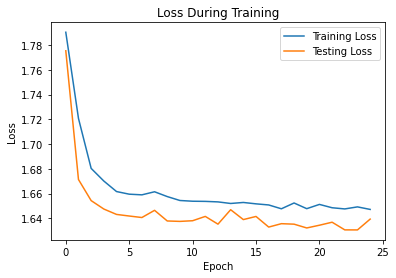

In [13]:
# === Plot the Data === #
plt.plot( history_dict['loss']     , label='Training Loss' )
plt.plot( history_dict['val_loss'] , label='Testing Loss' )

# === Label the Chart === #
plt.xlabel( 'Epoch' )
plt.ylabel( 'Loss' )
plt.title( 'Loss During Training' )
plt.legend( )

# === Display the Chart === #
plt.show( )

## Visualize Accuracy

This next cell shows a plot of the training and validation accuracy for the model (the exact results are saved in a future cell for later processing in another notebook.

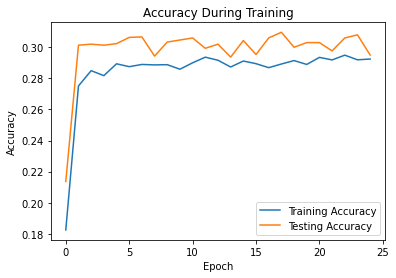

In [14]:
# === Plot the Data === #
plt.plot( history_dict['accuracy']     , label='Training Accuracy' )
plt.plot( history_dict['val_accuracy'] , label='Testing Accuracy'  )

# === Label the Chart === #
plt.xlabel( 'Epoch' )
plt.ylabel( 'Accuracy' )
plt.title( 'Accuracy During Training' )
plt.legend( )

# === Display the Chart === #
plt.show( )

## Save the Model 

Now that the model has been fully trained, we want to save the learned weights in order to be further evaluated later if needed. 

In [15]:
# === Save for Future Evaluation === #
hypermodel.save( 'LSH_Results/TUNED_vgg19_intel_model.h5' )

## Display Runtimes

We will show the measured preprocessing overhead time and the training time of this program in order to gain an understanding of the behavior of this baseline application. These resutls are saved in a future slide for later processing in a different notebook. 

In [16]:
for t in times:
    print( '{}: {}s'.format( t['Event'] , round( t['Time (sec)'] , 4 ) ) )

Load/Process Dataset: 11.3163s
Create Hash Functions: 0.0296s
Hashing Datasets: 350.4374s
Hyperparameter Tuning: 438.062s
Training: 526.3991s


## Save Time Data

The above data is converted into a pandas DataFrame for saving into a formatted CSV file. This csv file will be used for processing in a different notebook. 

In [17]:
time_data  = {
    'Event': [t['Event'] for t in times],
    'Time (sec)': [t['Time (sec)'] for t in times]
}
time_table = pd.DataFrame( time_data )
time_table.to_csv( 'LSH_Results/TUNED_vgg19_intel_times.csv' , index=False )
time_table.head( )

,Event,Time (sec)
0,Load/Process Dataset,11.316256
1,Create Hash Functions,0.029640
2,Hashing Datasets,350.437393
3,Hyperparameter Tuning,438.062009
4,Training,526.399109


## Save Training/Validation Data

Finally, construct a pandas dataframe of the training loss, validation loss, training accuracy, and validation accuracy at each epoch during training. These values are saved for processing in a different notebook. 

In [18]:
model_data = {
    'Epoch': [i+1 for i in range(25)],
    'Training Accuracy': history_dict['accuracy'],
    'Validation Accuracy': history_dict['val_accuracy'],
    'Training Loss': history_dict['loss'],
    'Validation Loss': history_dict['val_loss']
}
model_table = pd.DataFrame( model_data )
model_table.to_csv( 'LSH_Results/TUNED_vgg19_intel_history.csv' , index=False )
model_table.head( len( model_table ) )

,Epoch,Training Accuracy,Validation Accuracy,Training Loss,Validation Loss
0,1,0.182485,0.213667,1.790296,1.775312
1,2,0.275118,0.301333,1.720689,1.671331
2,3,0.284951,0.302000,1.680309,1.654285
3,4,0.281744,0.301333,1.670091,1.647480
4,5,0.289369,0.302333,1.661609,1.643128
5,6,0.287516,0.306333,1.659483,1.641841
6,7,0.288941,0.306667,1.658947,1.640623
7,8,0.288656,0.294333,1.661425,1.646434
8,9,0.288799,0.303333,1.657545,1.637841
9,10,0.285877,0.304667,1.654381,1.637498
